# Préparez des données pour un organisme de santé publique - Nettoyage

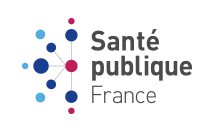

# Sommaire


* [1. Importation des librairies, définition des fonctions et importation du fichier](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Définition des fonctions](#1_2)
    * [1.3 Importation du fichier](#1_3)
* [2. Nettoyage du Dataframe](#2)
    * [2.1 Visualisation du Dataframe](#2_1)
    * [2.2 Le type des données](#2_2)
    * [2.3 Lignes en double et identification des valeurs manquantes](#2_3)
    * [2.4 Vérification des variables restantes](#2_4)
        * [2.4.1 Supression des variables de métadonnées](#2_4_1)
        * [2.4.2 Suppression des variables similaires](#2_4_2)
        * [2.4.3 Suppression des variables non utiles à l'application](#2_4_3)
            * [2.4.3.1 Variables qualitatives](#2_4_3_1)
            * [2.4.3.2 Variables quantitatives](#2_4_3_2)
    * [2.5 Dataset après nettoyage des variables](#2_5)
    * [2.6 Recherche de valeurs aberrantes ou atypiques](#2_6)
        * [2.6.1 Pour les valeurs nutritionnelles](#2_6_1)
        * [2.6.2 Pour l'énergie pour 100g](#2_6_2)
    * [2.7 Gestion des valeurs manquantes](#2_7)
        * [2.7.1 Les valeurs non estimables](#2_7_1)
        * [2.7.2 Les valeurs à imputer](#2_7_2)
            * [2.7.2.1 Imputation par la moyenne](#2_7_2_1)
            * [2.7.2.2 Imputation par la médiane](#2_7_2_2)
            * [2.7.2.3 Imputation par un KNNImputer](#2_7_2_3)
            * [2.7.2.4 Comparaison des méthodes](#2_7_2_4)
        * [2.7.3 Calcul de l'énergie pour 100g](#2_7_3)
        * [2.7.4 Calcul des grades des nutris-scores](#2_7_4)
        * [2.7.5 Affichage des informations du Dataframe nettoyé](#2_7_5)

__Contexte__ : Dans un contexte de préoccupation croissante pour la santé et le bien-être, nous développons une application basée sur les données d'Open Food Facts. Cette application permettra une autocomplétion des valeurs à remplir pour les aliments.
En effet, la donnée étant importante, il faut permettre à l'utilisateur du fichier de remplir plus efficacement le tableau.

## 1. Importation des librairies, définition des fonctions et importation du fichier <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

### 1.2 Définition des fonctions <a class="anchor" id="1_2"></a>

In [2]:
# Fonction dataframe pourcentage de valeurs manquantes
def pourcentage(df, dictionnaire):
    pourcentage_valeurs_manquantes = (df.isna().sum() / len(df)) * 100
    df_pourcentage_manquant = pd.DataFrame({'Nom de la colonne': pourcentage_valeurs_manquantes.index,
                                            'Pourcentage de valeurs manquantes': pourcentage_valeurs_manquantes.values})
    df_pourcentage_manquant['Type de variable'] = df_pourcentage_manquant['Nom de la colonne'].map(dictionnaire)
    df_pourcentage_manquant = df_pourcentage_manquant.sort_values('Pourcentage de valeurs manquantes', 
                                                                  ascending=False).reset_index(drop=True)
    return df_pourcentage_manquant

# Fonction de Levenshtein
def levenshtein(chaine1, chaine2):
    taille_chaine1 = len(chaine1) + 1
    taille_chaine2 = len(chaine2) + 1
    levenshtein_matrix = np.zeros ((taille_chaine1, taille_chaine2))
    for x in range(taille_chaine1):
        levenshtein_matrix [x, 0] = x
    for y in range(taille_chaine2):
        levenshtein_matrix [0, y] = y
    for x in range(1, taille_chaine1):
        for y in range(1, taille_chaine2):
            if chaine1[x-1] == chaine2[y-1]:
                levenshtein_matrix [x,y] = min(
                    levenshtein_matrix[x-1, y] + 1,
                    levenshtein_matrix[x-1, y-1],
                    levenshtein_matrix[x, y-1] + 1
                )
            else:
                levenshtein_matrix [x,y] = min(
                    levenshtein_matrix[x-1,y] + 1,
                    levenshtein_matrix[x-1,y-1] + 1,
                    levenshtein_matrix[x,y-1] + 1
                )
    return (levenshtein_matrix[taille_chaine1 - 1, taille_chaine2 - 1])

# Fonction pour supprimer les colonnes seulement si elles existent en alimentant une liste de colonnes a supprimer
# + mise à jour du dictionnaire des types
def suppression(df, dictionnaire, colonnes_a_supprimer, colonnes_a_ne_pas_supprimer):
    colonnes_a_supprimer_existantes = []
    for colonnes in colonnes_a_supprimer:
        if colonnes in df.columns:
            colonnes_a_supprimer_existantes.append(colonnes)
            
    colonnes_a_ne_pas_supprimer_existantes = []
    for colonnes in colonnes_a_ne_pas_supprimer:
        if colonnes in df.columns:
            colonnes_a_ne_pas_supprimer_existantes.append(colonnes)
    
    if len(colonnes_a_ne_pas_supprimer_existantes) > 0:
        for colonnes in colonnes_a_supprimer_existantes:
            if colonnes in colonnes_a_ne_pas_supprimer_existantes:
                colonnes_a_supprimer_existantes.remove(colonnes)
        
    if len(colonnes_a_supprimer_existantes) > 0:
        df = df.drop(columns=colonnes_a_supprimer_existantes)
        for colonnes in colonnes_a_supprimer_existantes:
            del dictionnaire[colonnes] # Mise à jour du dictionnaire (quali/ quanti)
    return df

# Fonction de visualisation des colonnes à traiter seulement si elles existent
def visualisation(df, liste_colonnes):
    colonnes_existantes = []
    for colonnes in liste_colonnes:
        if colonnes in df.columns:
            colonnes_existantes.append(colonnes)
            if len(colonnes_existantes) > 0:
                visualisation = df[colonnes_existantes].sample(10)
    return visualisation

# Fonction de visualisation des pourcentages de valeurs manquantes des colonnes à traiter
def visualisation_pourcentages(df, liste_colonnes):
    pourcentage_manquant = df[df['Nom de la colonne'].isin(liste_colonnes)]
    return pourcentage_manquant

# Fonction pour calculer le nutri-grade des boissons (sauf eau)
def grade_boissons(score):
    if score <= 1:
        return 'b'
    elif 2 <= score <= 5:
        return 'c'
    elif 6 <= score <= 9:
        return 'd'
    else:
        return 'e'
    
#Fonction pour calculer le nutri-grade des aliments
def grade_aliments(score):
    if score <= -1:
        return 'a'
    elif 0 <= score <= 2:
        return 'b'
    elif 3 <= score <= 10:
        return 'c'
    elif 11 <= score <= 18:
        return 'd'
    else:
        return 'e'

### 1.3 Importation du fichier <a class="anchor" id="1_3"></a>

In [3]:
# Création du Dataframe 'df_nutri'
df_nutri = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8', low_memory=False)

## 2. Nettoyage du Dataframe <a class="anchor" id="2"></a>

### 2.1 Visualisation du Dataframe <a class="anchor" id="2_1"></a>

In [4]:
# Prévisualisation du dataframe
pd.set_option("display.max_columns", None) # Pour afficher toutes les colonnes
df_nutri.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

In [5]:
# Vérifions les dimensions
print('Dimension du jeu de données :', df_nutri.shape)

Dimension du jeu de données : (320772, 162)


Nous pouvons consulter ce lien : https://fr.openfoodfacts.org/nutriscore pour comprendre comment le Nutri-Score est calculé. Pour construire notre modèle, nous aurons besoin des variables incluses dans ce calcul.

Le Nutri-Score est déterminé en fonction de la quantité de nutriments bons et mauvais pour la santé :

Points négatifs : l'énergie, les graisses saturées, les sucres et le sodium (des niveaux élevés sont considérés comme mauvais pour la santé).

Points positifs : la proportion de fruits, de légumes, de noix, d'huiles d'olive, de colza et de noix, de fibres et de protéines (des niveaux élevés sont considérés comme bénéfiques pour la santé).

Nous devons donc créer une liste des variables à conserver obligatoirement. Cette liste peut être générée à partir du lien suivant : https://world.openfoodfacts.org/data/data-fields.txt. Ce lien définit chacune des variables présentes dans le jeu de données.

In [6]:
# Création de la liste des variables du calcul du nutri-score
variables_calcul = ['energy_100g','energy-kj_100g','energy-kcal_100g','fat_100g','saturated-fat_100g',
                    'trans-fat_100g','cholesterol_100g','carbohydrates_100g','sugars_100g','fiber_100g',
                    'sodium_100g','proteins_100g','fruits-vegetables-nuts_100g','nutrition-score-fr_100g',
                   'nutrition_grade_fr']

### 2.2 Le type des données <a class="anchor" id="2_2"></a>

In [7]:
# Vérification du contenu du dataframe et du type de données
df_nutri.info()
df_type = df_nutri.dtypes.value_counts()

# Dictionnaire de remplacement pour identifier si le type de donnée correspond à une variable qualitative ou quantitative
dict_type = {}

for index in df_type.index:
    if index in ['int64', 'float64']:
        dict_type[index] = 'quantitatives'
    else:
        dict_type[index] = 'qualitatives'

# Utiliser .map() pour effectuer la correspondance avec le dictionnaire dict_type
df_type.index = df_type.index.map(dict_type)

# Afficher le dataframe
df_type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


quantitatives    106
qualitatives      56
dtype: int64

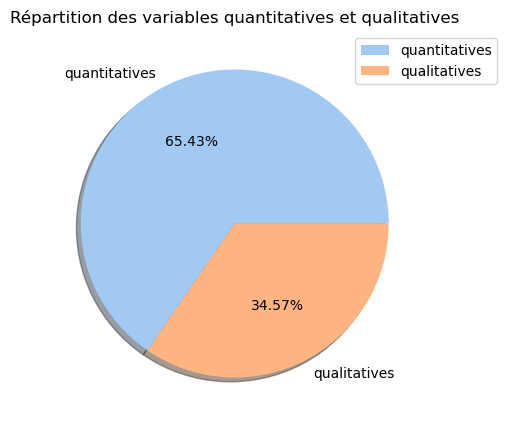

In [8]:
# Piechart de la répartition des variables qualitatives et quantitatives
plt.figure(figsize=(5,5))

colors = sns.color_palette("pastel")
labels = df_type.index

plt.pie(df_nutri.dtypes.value_counts(), labels=labels, autopct='%.2f%%', colors=colors, shadow=True)
plt.legend(labels, bbox_to_anchor=(1.2, 1))
plt.title("Répartition des variables quantitatives et qualitatives")
plt.show()

In [9]:
# Créer un dictionnaire pour attribuer le type "quantitative" ou "qualitative" à chaque colonne
dict_type = {}

for colonne in df_nutri.columns:
    if df_nutri[colonne].dtype in ['int64', 'float64']:
        dict_type[colonne] = 'quantitative'
    else:
        dict_type[colonne] = 'qualitative'

### 2.3 Lignes en double et identification des valeurs manquantes <a class="anchor" id="2_3"></a>

In [10]:
# Ligne en double
print(f"Il y a {df_nutri.duplicated().sum()} ligne(s) en double.")

Il y a 0 ligne(s) en double.


In [11]:
# Vérification des valeurs manquantes dans la colonne code
df_nutri.loc[df_nutri['code'].isna()]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
189068,NaN,NaN,villecomtal-sur-arros-gers-france,France,NaN,"Belgique,France","en:belgium,en:france","Belgique,France","Lait entier, fruits : fraise (20 %), mangue (1...",NaN,NaN,NaN,NaN,NaN,125 g (1 pot),NaN,6,[ lait-entier -> fr:lait-entier ] [ lait ->...,"en:e1422,en:e440,en:e412,en:e120,en:e160c,en:e101","E1422 - Adipate de diamidon acétylé,E440 - Pec...",0,NaN,NaN,0,NaN,NaN,NaN,b,Milk and dairy products,Milk and yogurt,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",en:whole-milk-yogurts,Yaourts entiers,http://fr.openfoodfacts.org/images/products/30...,http://fr.openfoodfacts.org/images/products/30...,95.2,NaN,3.2,2.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.1,12.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.24,3.44,NaN,NaN,NaN,0.1630,0.064000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189103,NaN,NaN,"villecomtal-sur-arros-gers-france,saint-just-c...","Villecresnes,Villeurbanne,France","Dia,Sogeres",France,en:france,France,"_Lait_ entie

23 lignes sans codes ni URL, on peut donc les supprimer.

In [12]:
# Seulement 23 lignes que nous décidons de supprimer
df_nutri = df_nutri[df_nutri['code'].notna()]

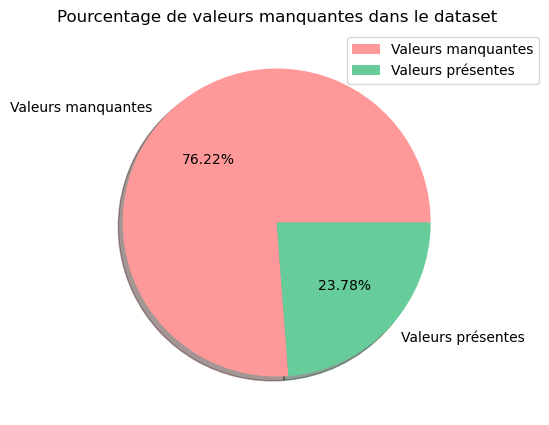

In [13]:
# Somme des valeurs manquantes
valeurs_manquantes = df_nutri.isna().sum().sum()

# Calcul du nombre total de valeurs
valeurs_totales = df_nutri.size

# Création d'un DataFrame pour les valeurs manquantes et présentes
df_valeurs_manquantes = pd.DataFrame({'Valeurs': ['Valeurs manquantes', 'Valeurs présentes'],
                   'Nombre': [valeurs_manquantes, valeurs_totales - valeurs_manquantes]})

# Calcul du pourcentage de valeurs manquantes
pourcentage_de_manquantes = (valeurs_manquantes / valeurs_totales) * 100

# Création du pie chart
plt.figure(figsize=(5,5))

colors = ['#FF9999', '#66CC99']
labels = df_valeurs_manquantes['Valeurs']

plt.pie(df_valeurs_manquantes['Nombre'], labels=labels, autopct='%.2f%%', colors=colors, shadow=True)
plt.legend(labels, bbox_to_anchor=(1.2, 1))
plt.title("Pourcentage de valeurs manquantes dans le dataset")
plt.show()

On se rend donc compte qu'il manque une grande partie des valeurs dans ce Dataset.

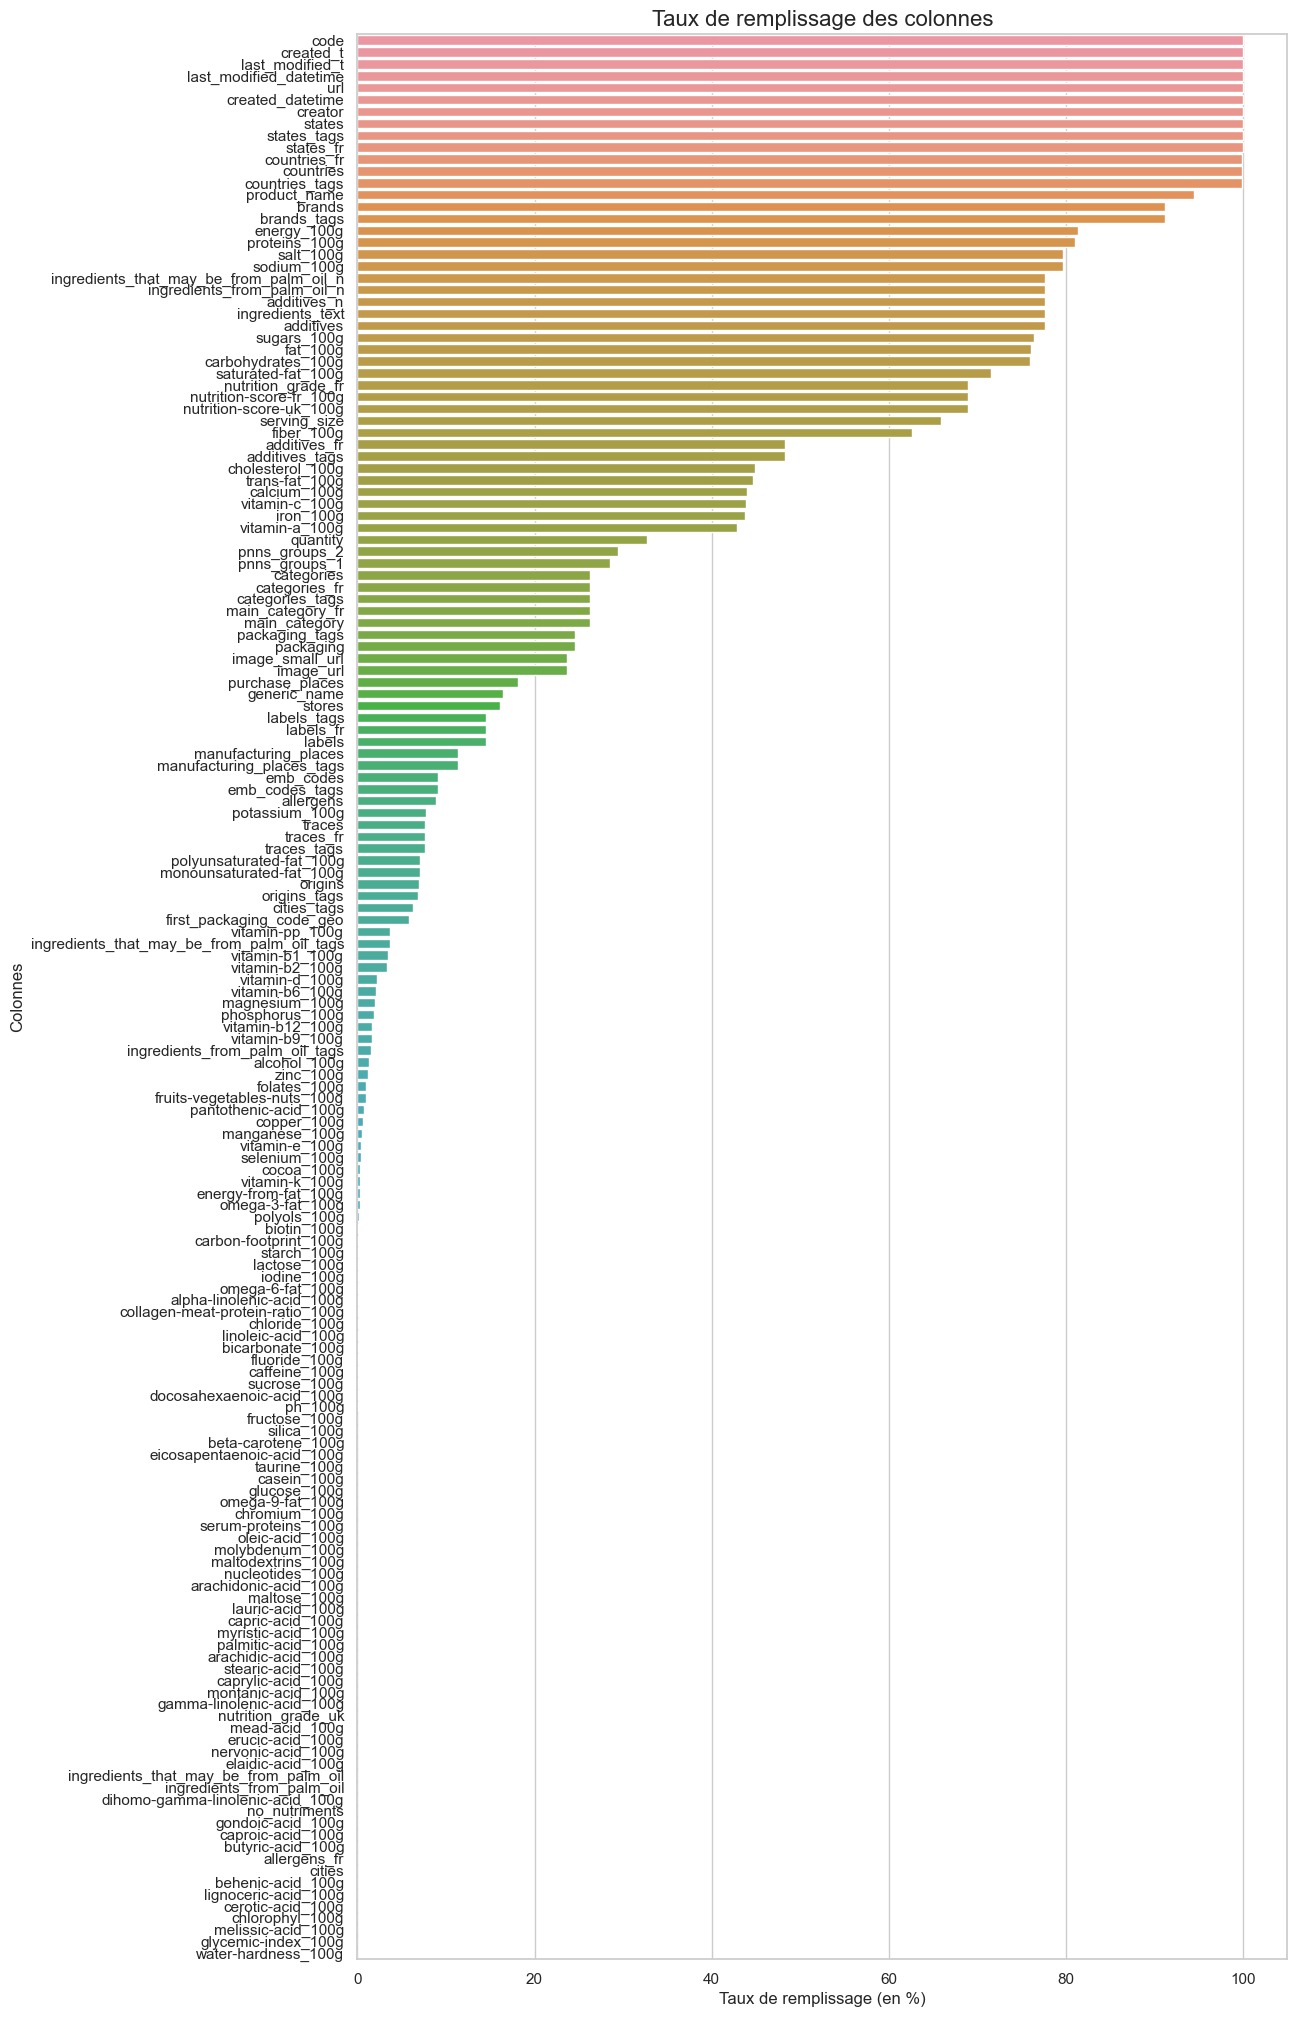

In [14]:
# Créer un Dataframe avec le pourcentage de valeurs manquantes (on appelle la fonction pourcentage)
df_pourcentage = pourcentage(df_nutri, dict_type)

# Calcul du taux de remplissage en soustrayant le taux de valeurs manquantes de 100%
df_pourcentage['Taux de remplissage'] = 100 - df_pourcentage['Pourcentage de valeurs manquantes']

# Tri du DataFrame par taux de remplissage
df_pourcentage = df_pourcentage.sort_values('Taux de remplissage', ascending=False)

# Création du graphique
plt.figure(figsize=(12, 25))
sns.set(style="whitegrid")
ax = sns.barplot(x="Taux de remplissage", y="Nom de la colonne", data=df_pourcentage)
plt.xlabel("Taux de remplissage (en %)")
plt.ylabel("Colonnes")
plt.title("Taux de remplissage des colonnes", fontsize=16)
plt.show()

Nous allons supprimer toutes les colonnes avec plus de 75% de valeurs manquantes. A condition que celles-ci ne soient pas dans la liste des variables pour le calcul du nutri-score. 

In [15]:
# Tri des colonnes avec pourcentage de valeurs manquantes supérieur à 75%
df_pourcentage_manquant_75 =  df_pourcentage.loc[df_pourcentage['Pourcentage de valeurs manquantes']>75]

# Sélection des colonnes à supprimer (plus de 75% de valeurs nulles)
colonnes_a_supprimer = []

for index, row in df_pourcentage_manquant_75.iterrows():
    nom_de_la_colonne = row['Nom de la colonne']
    colonnes_a_supprimer.append(nom_de_la_colonne)
        
# Suppression des colonnes sélectionnées avec vérifications de la liste variables_calcul
for colonnes in colonnes_a_supprimer:
    if colonnes in variables_calcul:
        colonnes_a_supprimer.remove(colonnes)

# Suppression des colonnes sélectionnées
df_nutri = df_nutri.drop(columns=colonnes_a_supprimer)

# Suppression des colonnes dans le dict_type
for colonnes in colonnes_a_supprimer:
    del dict_type[colonnes]
                       
# Affichage des dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)
print()
print("Liste des colonnes supprimées :", colonnes_a_supprimer)
print()
print("Liste des colonnes restantes :", df_nutri.columns)

Dimensions du dataframe après suppression des colonnes : (320749, 51)

Liste des colonnes supprimées : ['packaging_tags', 'packaging', 'image_small_url', 'image_url', 'purchase_places', 'generic_name', 'stores', 'labels_tags', 'labels_fr', 'labels', 'manufacturing_places', 'manufacturing_places_tags', 'emb_codes', 'emb_codes_tags', 'allergens', 'potassium_100g', 'traces', 'traces_fr', 'traces_tags', 'polyunsaturated-fat_100g', 'monounsaturated-fat_100g', 'origins', 'origins_tags', 'cities_tags', 'first_packaging_code_geo', 'vitamin-pp_100g', 'ingredients_that_may_be_from_palm_oil_tags', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-d_100g', 'vitamin-b6_100g', 'magnesium_100g', 'phosphorus_100g', 'vitamin-b12_100g', 'vitamin-b9_100g', 'ingredients_from_palm_oil_tags', 'alcohol_100g', 'zinc_100g', 'folates_100g', 'pantothenic-acid_100g', 'copper_100g', 'manganese_100g', 'vitamin-e_100g', 'selenium_100g', 'cocoa_100g', 'vitamin-k_100g', 'energy-from-fat_100g', 'omega-3-fat_100g', 'polyol

Nous allons également supprimer les lignes sans 'product_name'

In [16]:
# Supprimons les lignes qui contiennent des valeurs manquantes dans 'product_name'
df_nutri.dropna(subset=['product_name'], inplace=True)
print('Dimension du jeu de données :', df_nutri.shape)

Dimension du jeu de données : (302987, 51)


Nous allons également supprimer les lignes pour lesquelles aucunes données nutritionelles n'ont été renseignées.

In [17]:
# Liste des colonnes à vérifier
nutri_columns = df_nutri[[col for col in df_nutri.columns if col.endswith("_100g")]]

# Supprimer les lignes avec des valeurs manquantes dans les colonnes de nutriments
index_with_nan = nutri_columns.index[nutri_columns.isnull().mean(axis=1) == 1]
df_nutri = df_nutri.drop(index=index_with_nan)

# Réinitialiser l'index
df_nutri = df_nutri.reset_index(drop=True)

# Affichage des dimensions du dataframe après suppression et réinitialisation de l'index
print("Dimensions du dataframe après suppression et réinitialisation de l'index :", df_nutri.shape)

Dimensions du dataframe après suppression et réinitialisation de l'index : (259539, 51)


### 2.4 Vérification des variables restantes <a class="anchor" id="2_4"></a>

In [18]:
df_nutri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259539 entries, 0 to 259538
Data columns (total 51 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     259539 non-null  object 
 1   url                                      259539 non-null  object 
 2   creator                                  259539 non-null  object 
 3   created_t                                259539 non-null  object 
 4   created_datetime                         259538 non-null  object 
 5   last_modified_t                          259539 non-null  object 
 6   last_modified_datetime                   259539 non-null  object 
 7   product_name                             259539 non-null  object 
 8   quantity                                 69362 non-null   object 
 9   brands                                   256167 non-null  object 
 10  brands_tags                     

### 2.4.1 Supression des variables de métadonnées <a class="anchor" id="2_4_1"></a>

Maintenant que nous avons supprimé un bon nombre de colonnes et toujours grâce au fichier text : https://world.openfoodfacts.org/data/data-fields.txt, nous allons pouvoir identifier des colonnes qui ne seront pas utiles pour la suite de l'analyse. 

In [19]:
# Supprimons les colonnes qui ne seront pas utiles (métadonnées) on ne gardera que le code en guise d'ID
colonnes_a_supprimer = ['url', 'creator', 'created_t', 'created_datetime','last_modified_t', 'last_modified_datetime']

# Appellons la fonction 'suppression'
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)

# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 45)


### 2.4.2 Suppression des variables similaires <a class="anchor" id="2_4_2"></a>

Ensuite, le but va être de regarder la similarité entre les colonnes. En effet, avec les noms des variables, on peut s'appercevoir que certaines colonnes pourraient être des doublons d'information.

Pour comparer les variables similaires, on va utiliser l'algorithme de Levenshtein pour comparer les titre de colonnes et pouvoir créer des groupes avec similarité.

In [20]:
# Comparaison des titres des colonnes avec Levenshtein
similarite_minimale = 0.7 # Taux de similarité minimum (Distance de Levenshtein)

# Liste des noms de colonnes
noms_de_colonnes = df_nutri.columns

for i in range(len(noms_de_colonnes)):
    for j in range(i + 1, len(noms_de_colonnes)):
        nom_colonne_1 = noms_de_colonnes[i]
        nom_colonne_2 = noms_de_colonnes[j]
        similarite = 1 - levenshtein(nom_colonne_1, nom_colonne_2) / max(len(nom_colonne_1), len(nom_colonne_2))
        
        if similarite >= similarite_minimale:
            print(f"Similarité entre '{nom_colonne_1}' et '{nom_colonne_2}': {round(similarite, 2)}")
            print()

Similarité entre 'categories' et 'categories_fr': 0.77

Similarité entre 'categories_tags' et 'categories_fr': 0.73

Similarité entre 'countries' et 'countries_fr': 0.75

Similarité entre 'countries_tags' et 'countries_fr': 0.71

Similarité entre 'additives_n' et 'additives': 0.82

Similarité entre 'additives_n' et 'additives_tags': 0.71

Similarité entre 'additives_n' et 'additives_fr': 0.83

Similarité entre 'additives' et 'additives_fr': 0.75

Similarité entre 'additives_tags' et 'additives_fr': 0.71

Similarité entre 'pnns_groups_1' et 'pnns_groups_2': 0.92

Similarité entre 'main_category' et 'main_category_fr': 0.81

Similarité entre 'fat_100g' et 'salt_100g': 0.78

Similarité entre 'vitamin-a_100g' et 'vitamin-c_100g': 0.93

Similarité entre 'nutrition-score-fr_100g' et 'nutrition-score-uk_100g': 0.91



On peut donc identifier 8 groupes de variables similaires. 

In [21]:
# Créer les 8 groupes
categories = ['categories', 'categories_fr', 'categories_tags']

countries = ['countries', 'countries_fr', 'countries_tags']

additives = ['additives_n', 'additives', 'additives_tags', 'additives_fr']

pnns = ['pnns_groups_1', 'pnns_groups_2']

main_category = ['main_category', 'main_category_fr']

fat = ['fat_100g', 'salt_100g']

vitamin = ['vitamin-a_100g', 'vitamin-c_100g']

nutrition_score = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g']

#### Les catégories

In [22]:
# Visualisation des colonnes concernées
visualisation(df_nutri, categories)

,categories,categories_fr,categories_tags
115272,NaN,NaN,NaN
81546,NaN,NaN,NaN
76730,NaN,NaN,NaN
183333,"Snacks sucrés,Biscuits et gâteaux","Snacks sucrés,Biscuits et gâteaux","en:sugary-snacks,en:biscuits-and-cakes"
147796,NaN,NaN,NaN
80817,NaN,NaN,NaN
36599,NaN,NaN,NaN
195270,NaN,NaN,NaN
201479,Madeleines,"Snacks sucrés,Biscuits et gâteaux,Desserts,Gât...","en:sugary-snacks,en:biscuits-and-cakes,en:dess..."
202867,NaN,NaN,NaN


In [23]:
# Visualisation des pourcentages de valeurs manquantes sur les colonnes en question
visualisation_pourcentages(df_pourcentage, categories)

,Nom de la colonne,Pourcentage de valeurs manquantes,Type de variable,Taux de remplissage
114,categories,73.690019,qualitative,26.309981
116,categories_fr,73.690019,qualitative,26.309981
115,categories_tags,73.690019,qualitative,26.309981


Les 3 variables semblent similaires et ont le même pourcentage de valeurs manquantes, seul la langue change : on gardera donc la variables en français 'categories_fr'.

In [24]:
# Il faut alimenter la liste des colonnes à supprimer
colonnes_a_supprimer = ['categories', 'categories_tags']

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 43)


#### Countries

In [25]:
# Visualisation des colonnes concernées
visualisation(df_nutri, countries)

,countries,countries_fr,countries_tags
228350,Deutschland,Allemagne,en:germany
34205,US,États-Unis,en:united-states
131783,US,États-Unis,en:united-states
236162,France,France,en:france
250039,Suisse,Suisse,en:switzerland
75619,US,États-Unis,en:united-states
253293,España,Espagne,en:spain
250688,France,France,en:france
97315,US,États-Unis,en:united-states
154849,US,États-Unis,en:united-states


In [26]:
# Visualisation des pourcentages de valeurs manquantes sur les colonnes en question
visualisation_pourcentages(df_pourcentage, countries)

,Nom de la colonne,Pourcentage de valeurs manquantes,Type de variable,Taux de remplissage
151,countries_fr,0.087296,qualitative,99.912704
150,countries,0.087296,qualitative,99.912704
149,countries_tags,0.087296,qualitative,99.912704


Il s'agit bien de variables équivalente, nous allons garder 'countries_fr' qui est la variable en français.

In [27]:
# Il faut alimenter la liste des colonnes à supprimer
colonnes_a_supprimer = ['countries', 'countries_tags']

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 41)


#### Additives

In [28]:
# Visualisation des colonnes concernées
visualisation(df_nutri, additives)

,additives_n,additives,additives_tags,additives_fr
118633,0.0,[ sugar -> en:sugar ] [ wheat-flour -> en:w...,NaN,NaN
192012,5.0,[ filet-de-sole-tropicale-68 -> fr:filet-de-s...,"en:e450,en:e1400,en:e461,en:e160,en:e500","E450 - Sels métalliques de diphosphates,E1400 ..."
40987,0.0,[ ground-white-corn -> en:ground-white-corn ...,NaN,NaN
165313,0.0,[ bison -> en:bison ] [ water -> en:water ...,NaN,NaN
66768,0.0,[ cooked-white-rice -> en:cooked-white-rice ...,NaN,NaN
70197,1.0,[ green-tea -> en:green-tea ] [ tea -> en:t...,en:e300,E300 - Acide ascorbique
63866,4.0,[ cultured-pasteurized-grade-a-lowfat-milk ->...,"en:e428,en:e160b,en:e330,en:e201","E428 - Gélatine,E160b - Rocou,E330 - Acide cit..."
204546,5.0,[ biscuit-52 -> fr:biscuit-52 ] [ biscuit -...,"en:e503,en:e500,en:e450,en:e330,en:e322","E503 - Carbonates d'ammonium,E500 - Carbonates..."
194805,9.0,[ fruits-32 -> fr:fruits-32 ] [ fruits -> f...,"en:e330,en:e202,en:e127,en:e471,en:e422,en:e45...","E330 - Acide citrique,E202 - Sorbate de potass..."
167798,0.0,[ black-cherry-juice -> en:black-cherry-juice...,NaN,NaN


In [29]:
# Visualisation des pourcentages de valeurs manquantes sur les colonnes en question
visualisation_pourcentages(df_pourcentage, additives)

,Nom de la colonne,Pourcentage de valeurs manquantes,Type de variable,Taux de remplissage
139,additives_n,22.388223,quantitative,77.611777
137,additives,22.398823,qualitative,77.601177
127,additives_fr,51.775376,qualitative,48.224624
126,additives_tags,51.775376,qualitative,48.224624


On va garder 'additives_n' et 'additives_fr' afin d'avoir le nombre d'additifs ainsi que la liste en français. Les autres variables ne nous apporterons pas plus d'éléments sur les additifs.

In [30]:
# Il faut alimenter la liste des colonnes à supprimer
colonnes_a_supprimer = ['additives', 'additives_tags']

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 39)


#### Pnns

In [31]:
# Visualisation des colonnes concernées
visualisation(df_nutri, pnns)

,pnns_groups_1,pnns_groups_2
3093,NaN,NaN
11895,NaN,NaN
239002,NaN,NaN
31513,unknown,unknown
142887,NaN,NaN
53725,NaN,NaN
237880,Cereals and potatoes,Cereals
98557,NaN,NaN
107517,NaN,NaN
180641,Sugary snacks,Sweets


In [32]:
# Visualisation des pourcentages de valeurs manquantes sur les colonnes en question
pourcentage_manquant = visualisation_pourcentages(df_pourcentage, pnns)
pourcentage_manquant

,Nom de la colonne,Pourcentage de valeurs manquantes,Type de variable,Taux de remplissage
118,pnns_groups_2,70.540516,qualitative,29.459484
117,pnns_groups_1,71.468968,qualitative,28.531032


Il s'agit de colonnes identiques, mais il faut garder celle avec le pourcentage de valeurs manquantes le plus faible.

In [33]:
# Il faut alimenter la liste des colonnes à garder
colonnes_a_garder = pourcentage_manquant.loc[pourcentage_manquant['Pourcentage de valeurs manquantes'].idxmin()]
colonnes_a_garder = colonnes_a_garder['Nom de la colonne']

# On enlève la colonne à garde de la liste
pnns.remove(colonnes_a_garder)

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, pnns, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 38)


#### Main_category

In [34]:
# Visualisation des colonnes concernées
visualisation(df_nutri, main_category)

,main_category,main_category_fr
48434,NaN,NaN
46452,NaN,NaN
85503,NaN,NaN
51607,NaN,NaN
217209,en:crepes-and-galettes,Crêpes et galettes
207501,en:plant-based-foods-and-beverages,Aliments et boissons à base de végétaux
168281,NaN,NaN
42171,NaN,NaN
134437,NaN,NaN
185151,en:french-cheeses,Fromages de France


In [35]:
# Visualisation des pourcentages de valeurs manquantes sur les colonnes en question
visualisation_pourcentages(df_pourcentage, main_category)

,Nom de la colonne,Pourcentage de valeurs manquantes,Type de variable,Taux de remplissage
112,main_category_fr,73.69719,qualitative,26.30281
113,main_category,73.69719,qualitative,26.30281


In [36]:
# Il faut alimenter la liste des colonnes à supprimer
colonnes_a_supprimer = ['main_category']

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 37)


#### Fat

In [37]:
# Visualisation des colonnes concernées
visualisation(df_nutri, fat)

,fat_100g,salt_100g
22275,1.79,0.00000
145835,32.50,0.15748
187164,NaN,0.00000
100639,0.00,0.05080
91609,16.67,2.11582
11195,23.68,0.16764
27081,25.00,3.01752
179463,NaN,0.25000
37707,0.00,0.06096
135236,25.00,0.00000


Les variables n'ont aucune similitude.

#### Vitamin

In [38]:
# Visualisation des colonnes concernées
visualisation(df_nutri, vitamin)

,vitamin-a_100g,vitamin-c_100g
121074,0.000000,0.0000
5963,0.000000,0.0000
87027,0.000000,0.3243
77198,0.000071,0.0000
6481,NaN,NaN
41454,0.000176,0.0042
50493,0.000000,0.0043
125536,0.000364,0.0182
92887,0.000113,0.0034
88422,0.000000,0.0000


Les variables n'ont aucune similitude.

#### Nutrition_score

In [39]:
# Visualisation des colonnes concernées
visualisation(df_nutri, nutrition_score)

,nutrition-score-fr_100g,nutrition-score-uk_100g
224767,14.0,14.0
567,9.0,9.0
25462,-4.0,-4.0
35083,0.0,0.0
221101,11.0,11.0
71261,33.0,33.0
113435,15.0,15.0
147823,-1.0,-1.0
47520,2.0,2.0
241245,1.0,1.0


In [40]:
# Visualisation des pourcentages de valeurs manquantes sur les colonnes en question
visualisation_pourcentages(df_pourcentage, nutrition_score)

,Nom de la colonne,Pourcentage de valeurs manquantes,Type de variable,Taux de remplissage
131,nutrition-score-fr_100g,31.0333,quantitative,68.9667
130,nutrition-score-uk_100g,31.0333,quantitative,68.9667


On va garder 'nutrition-score-fr_100g'.

In [41]:
# Il faut alimenter la liste des colonnes à supprimer
colonnes_a_supprimer = ['nutrition-score-uk_100g']

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 36)


### 2.4.3 Suppression des variables non utiles à l'application <a class="anchor" id="2_4_3"></a>

##### 2.4.3.1 Variables qualitatives <a class="anchor" id="2_4_3_1"></a>

Pour les variables qualitatives, nous pouvons séparer en plusieurs groupes afin de pouvoir travailler sur la sélection.

Nous nous aiderons de la description du fichier disponible sur : https://world.openfoodfacts.org/data/data-fields.txt.

#### Les informations générales

In [42]:
# Création de la liste des variables contenant les informations générales sur les produits
general_information = ['product_name','quantity']

# Visualisation des colonnes concernées
visualisation(df_nutri, general_information)

,product_name,quantity
258147,พัลพิ,290 mL
90946,Lorraine Petite Quiche,NaN
20861,Mini Powdered Donuts,10 OZ
231695,Sundried Tomato & Herb,150 g
95066,"Potato Chips, Queso",NaN
251718,Collezione Spaghetti Rigati,500 g
57697,Summer Sausage,NaN
203405,Tentation Pâtissière 0 % (panachés),NaN
1784,"Sparking Water, Lemon Lime",NaN
152433,Eduardo's Elbow Macaroni Egg Pasta,NaN


Nous ne garderons que la variable 'product_name' dans les informations générales.

In [43]:
# Il faut alimenter la liste des colonnes à supprimer
colonnes_a_supprimer = ['quantity']

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 35)


#### Les variables 'tags'

In [44]:
# Création de la liste des variables contenant les informations générales sur les produits
tags = ['brands','brands_tags','categories_fr','countries_fr', 'ingredients_text']

# Visualisation des colonnes concernées
visualisation(df_nutri, tags)

,brands,brands_tags,categories_fr,countries_fr,ingredients_text
141585,"Valued Naturals, International Foodsource","valued-naturals,international-foodsource",NaN,États-Unis,Brazil nuts.
145693,Parisian Star,parisian-star,NaN,États-Unis,"Unbleached enriched wheat flour (flour, niacin..."
4900,Roundy's Select,roundy-s-select,NaN,États-Unis,"Whole milk, sugar, dark chocolate (cocoa of do..."
100371,"Market Pantry, Target Stores","market-pantry,target-stores",NaN,États-Unis,Low-moisture part-skim mozzarella cheese (past...
182519,CEMOI,cemoi,"Snacks sucrés,Confiseries,Desserts,Chocolats,C...",France,"Pâte de cacao*, sucre*, céréales croustillante..."
239519,La Costeña,la-costena,"Aliments et boissons à base de végétaux,Alimen...",France,"Piment chipotle (22%)(Piment Chipotle sec, Eau..."
144001,Buddyfruits,buddyfruits,NaN,États-Unis,"Apples, banana puree, greek yogurt*, raspberry..."
37114,West Coast Grocery Company,west-coast-grocery-company,NaN,États-Unis,"Unbleached flour (wheat flour, malted barley f..."
213356,P'tit Deli,p-tit-deli,NaN,France,NaN
211565,"Carrefour,CMI (Carrefour Marchandises Internat...","carrefour,cmi-carrefour-marchandises-internati...","Frais,Viandes,Charcuteries,Jambons,Porc,Charcu...",France,Jambon de porc issu d'animaux nourris sans OGM...


In [45]:
# Visualisation des pourcentages de valeurs manquantes sur les colonnes en question
visualisation_pourcentages(df_pourcentage, tags)

,Nom de la colonne,Pourcentage de valeurs manquantes,Type de variable,Taux de remplissage
151,countries_fr,0.087296,qualitative,99.912704
147,brands,8.850846,qualitative,91.149154
146,brands_tags,8.853340,qualitative,91.146660
138,ingredients_text,22.388223,qualitative,77.611777
116,categories_fr,73.690019,qualitative,26.309981


Ici, on peut voir que certaines variables similaires n'ont pas étaient détectée précedemment ('brands_tags' et 'brands')

On va donc garder les variables contenant le plus de données : brands.

On supprimera également ingredients_text.

In [46]:
# Il faut alimenter la liste des colonnes à supprimer
colonnes_a_supprimer = ['brands_tags', 'ingredients_text']

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 33)


#### Les variables restantes

In [47]:
# Création de la liste des variables contenant les informations générales sur les produits
reste = ['serving_size','additives_fr','nutrition_grade_fr','pnns_groups_2','states','states_tags',
         'states_fr','main_category_fr']

# Visualisation des colonnes concernées
visualisation(df_nutri, reste)

,serving_size,additives_fr,nutrition_grade_fr,pnns_groups_2,states,states_tags,states_fr,main_category_fr
125043,124 g (0.333 PIZZA),E412 - Gomme de guar,d,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN
242072,330 g,NaN,e,Non-sugared beverages,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",Boissons
209493,NaN,NaN,a,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN
90827,42 g (10 PIECES),"E965 - Maltitol,E322 - Lécithines,E955 - Sucra...",c,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN
147082,100 g (1 cup),E415 - Gomme xanthane,b,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN
117600,105 g (4 fl oz),"E412 - Gomme de guar,E410 - Farine de graines ...",c,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN
64674,50 g (1 BUNDLE),NaN,b,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN
145504,50 g (1 ROLL),E464 - Hydroxypropylméthylcellulose,b,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN
58145,30 g (2 Tbsp),"E415 - Gomme xanthane,E330 - Acide citrique,E3...",d,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN
79518,84 g (3 oz),"E955 - Sucralose,E415 - Gomme xanthane,E500ii ...",c,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN


In [48]:
# Visualisation des pourcentages de valeurs manquantes sur les colonnes en question
visualisation_pourcentages(df_pourcentage, reste)

,Nom de la colonne,Pourcentage de valeurs manquantes,Type de variable,Taux de remplissage
152,states,0.007171,qualitative,99.992829
153,states_tags,0.007171,qualitative,99.992829
154,states_fr,0.007171,qualitative,99.992829
132,nutrition_grade_fr,31.033300,qualitative,68.966700
129,serving_size,34.120449,qualitative,65.879551
127,additives_fr,51.775376,qualitative,48.224624
118,pnns_groups_2,70.540516,qualitative,29.459484
112,main_category_fr,73.697190,qualitative,26.302810


Ici encore, on peut constater que certaines variables similaires n'avaient pas été détectées précédemment. Cependant, nous ne conserverons aucune d'entre elles, car l'état actuel ('states', 'states_tags' et 'states_fr') ne nous sera d'aucune utilité. De plus, nous pouvons supprimer la variable 'serving_size', car le nutriscore n'est pas calculé en fonction des portions, mais plutôt sur la base de 100g de l'aliment.

In [49]:
# Il faut alimenter la liste des colonnes à supprimer
colonnes_a_supprimer = ['states', 'states_tags', 'states_fr', 'serving_size']

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :",df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 29)


##### 2.4.3.2 Variables quantitatives <a class="anchor" id="2_4_3_2"></a>

In [50]:
# Liste des variables quantitatives
variables_quanti = []

for colonne, variable in dict_type.items():
    if variable == 'quantitative':
        variables_quanti.append(colonne)
        
# Afficher la liste des variables quantitatives
print("Variables quantitatives :", variables_quanti)

Variables quantitatives : ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g']


In [51]:
# Visualisation des colonnes concernées
visualisation(df_nutri, variables_quanti)

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
32262,1.0,0.0,0.0,929.0,0.00,0.0,0.0,0.000,66.67,22.22,0.0,0.00,22.57806,8.889000,0.000667,0.0000,0.000,0.00000,NaN,16.0
213627,NaN,NaN,NaN,1527.0,NaN,1.0,NaN,NaN,NaN,44.80,2.1,7.50,0.54500,0.214567,NaN,NaN,NaN,NaN,NaN,13.0
256956,2.0,1.0,0.0,2077.0,28.12,24.6,NaN,NaN,61.66,59.13,NaN,3.48,0.49000,0.192913,NaN,NaN,NaN,NaN,NaN,28.0
107453,2.0,0.0,0.0,222.0,0.00,0.0,0.0,0.000,12.39,10.62,1.8,0.00,0.06858,0.027000,0.000000,0.0531,0.018,0.00032,NaN,0.0
93210,0.0,0.0,0.0,1644.0,0.00,0.0,0.0,0.000,82.14,7.14,3.6,10.71,2.99466,1.179000,0.000000,0.0000,0.000,0.00000,NaN,10.0
179707,NaN,NaN,NaN,1360.0,27.50,18.5,NaN,NaN,0.50,0.50,NaN,20.00,1.80000,0.708661,NaN,NaN,0.690,NaN,NaN,16.0
235668,5.0,0.0,0.0,1920.0,8.00,0.7,NaN,NaN,2.20,1.40,NaN,1.00,1.00000,0.393701,NaN,NaN,NaN,NaN,NaN,9.0
176358,NaN,NaN,NaN,264.0,NaN,0.2,NaN,NaN,NaN,3.70,4.2,3.40,0.57000,0.224409,NaN,NaN,NaN,NaN,NaN,-5.0
4640,0.0,0.0,0.0,1046.0,0.00,0.0,0.0,0.000,65.00,37.50,7.5,2.50,0.00000,0.000000,0.000225,0.0000,0.050,0.00090,NaN,6.0
57685,4.0,0.0,0.0,1343.0,3.57,0.0,0.0,0.089,21.43,21.43,0.0,39.29,4.35356,1.714000,0.000000,0.0000,0.000,0.00386,NaN,18.0


Nous pouvons supprimer la variable 'ingredients_that_may_be_from_palm_oil_n' car elle ne fournit pas d'informations nutritionnelles significatives pour notre analyse.

In [52]:
# Il faut alimenter la liste des colonnes à supprimer
colonnes_a_supprimer = ['ingredients_that_may_be_from_palm_oil_n']

# Supprimons la/les colonne(s) non utile(s)
df_nutri = suppression(df_nutri, dict_type, colonnes_a_supprimer, variables_calcul)
        
# Affichons les dimensions du dataframe après suppression
print("Dimensions du dataframe après suppression des colonnes :", df_nutri.shape)

Dimensions du dataframe après suppression des colonnes : (259539, 28)


### 2.5 Dataset après nettoyage des variables <a class="anchor" id="2_5"></a>

In [53]:
# Prévisualisation du Dataframe
df_nutri.head()

,code,product_name,brands,categories_fr,countries_fr,additives_n,additives_fr,ingredients_from_palm_oil_n,nutrition_grade_fr,pnns_groups_2,main_category_fr,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000000004530,Banana Chips Sweetened (Whole),NaN,NaN,États-Unis,0.0,NaN,0.0,d,NaN,NaN,2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,NaN,14.0
1,0000000004559,Peanuts,Torn & Glasser,NaN,États-Unis,0.0,NaN,0.0,b,NaN,NaN,1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,NaN,0.0
2,0000000016087,Organic Salted Nut Mix,Grizzlies,NaN,États-Unis,0.0,NaN,0.0,d,NaN,NaN,2540.0,57.14,5.36,NaN,NaN,17.86,3.57,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,NaN,12.0
3,0000000016094,Organic Polenta,Bob's Red Mill,NaN,États-Unis,0.0,NaN,0.0,NaN,NaN,NaN,1552.0,1.43,NaN,NaN,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000016100,Breadshop Honey Gone Nuts Granola,Unfi,NaN,États-Unis,0.0,NaN,0.0,NaN,NaN,NaN,1933.0,18.27,1.92,NaN,NaN,63.46,11.54,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN


In [54]:
# Vérifions les dimensions
print('Dimension du jeu de données :', df_nutri.shape)

Dimension du jeu de données : (259539, 28)


In [55]:
# Vérification du contenu du dataframe et du type de données
df_nutri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259539 entries, 0 to 259538
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   code                         259539 non-null  object 
 1   product_name                 259539 non-null  object 
 2   brands                       256167 non-null  object 
 3   categories_fr                64109 non-null   object 
 4   countries_fr                 259474 non-null  object 
 5   additives_n                  234027 non-null  float64
 6   additives_fr                 149577 non-null  object 
 7   ingredients_from_palm_oil_n  234027 non-null  float64
 8   nutrition_grade_fr           218463 non-null  object 
 9   pnns_groups_2                68369 non-null   object 
 10  main_category_fr             64109 non-null   object 
 11  energy_100g                  257773 non-null  float64
 12  fat_100g                     240584 non-null  float64
 13 

### 2.6 Recherche de valeurs aberrantes ou atypiques <a class="anchor" id="2_6"></a>

In [56]:
# Affichons un describe pour la variables quantitatives
df_nutri.describe()

,additives_n,ingredients_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
count,234027.000000,234027.000000,2.577730e+05,240584.000000,226641.000000,143159.000000,143950.000000,240276.000000,241910.000000,198587.000000,256605.000000,252527.000000,252488.000000,137398.000000,140655.00000,140837.000000,140305.000000,3032.000000,218463.000000
mean,1.994035,0.018771,1.140497e+03,12.701388,5.115709,0.073428,0.020079,32.091647,15.993129,2.863581,7.074330,2.037957,0.802467,0.000397,0.02335,0.125119,0.003654,31.489865,9.151724
std,2.516128,0.137406,6.484434e+03,17.574028,8.008095,1.540612,0.358234,29.765368,22.345150,12.933636,8.418758,129.023620,50.800621,0.073320,2.23813,3.320757,0.214528,31.975718,9.052588
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-3.570000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000,-0.000340,-0.00210,0.000000,-0.000260,0.000000,-15.000000
25%,0.000000,0.000000,3.730000e+02,0.000000,0.000000,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,0.025000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,1.100000e+03,5.000000,1.790000,0.000000,0.000000,20.600000,5.710000,1.500000,4.760000,0.584200,0.230000,0.000000,0.00000,0.035000,0.001010,23.000000,10.000000
75%,3.000000,0.000000,1.674000e+03,20.000000,7.140000,0.000000,0.020000,58.500000,24.000000,3.600000,10.000000,1.379220,0.543000,0.000107,0.00370,0.106000,0.002400,51.000000,16.000000
max,31.000000,2.000000,3.251373e+06,714.290000,550.000000,369.000000,95.238000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,26.700000,716.98110,694.737000,50.000000,100.000000,40.000000


Nous n'avons pas observé d'irrégularités significatives pour le nutri-score, qui varie de -15 à 40, ni pour le nombre d'additifs ou le nombre d'ingrédients issus de l'huile de palme.

Cependant, nous avons remarqué que certaines valeurs maximales semblent aberrantes. En effet, pour 100 g du produit, les valeurs nutritionnelles ne peuvent pas dépasser 100 g, et les données doivent donc être comprises entre 0 et 100. Nous remplacerons ces valeurs aberrantes par des valeurs manquantes.

De plus, en ce qui concerne l'énergie contenue dans 100 g, nous avons observé une grande disparité entre les 75 % des aliments et le maximum. En effet, 75 % des aliments ont une valeur énergétique inférieure à 1 674 kJ, tandis que le maximum atteint 3 251 373 kJ.

#### 2.6.1 Pour les valeurs nutritionnelles <a class="anchor" id="2_6_1"></a>

In [57]:
# Alimenter la liste des nutriments avec les noms de colonnes qui terminent par '_100g'
nutriments = []

for colonnes in df_nutri.columns:
    if '_100g' in colonnes:
        nutriments.append(colonnes)
        
# Enlever le nutriscore et l'énergie de la liste des nutriments
if 'nutrition-score-fr_100g' in nutriments:
    nutriments.remove('nutrition-score-fr_100g')
if 'energy_100g' in nutriments:
    nutriments.remove('energy_100g')

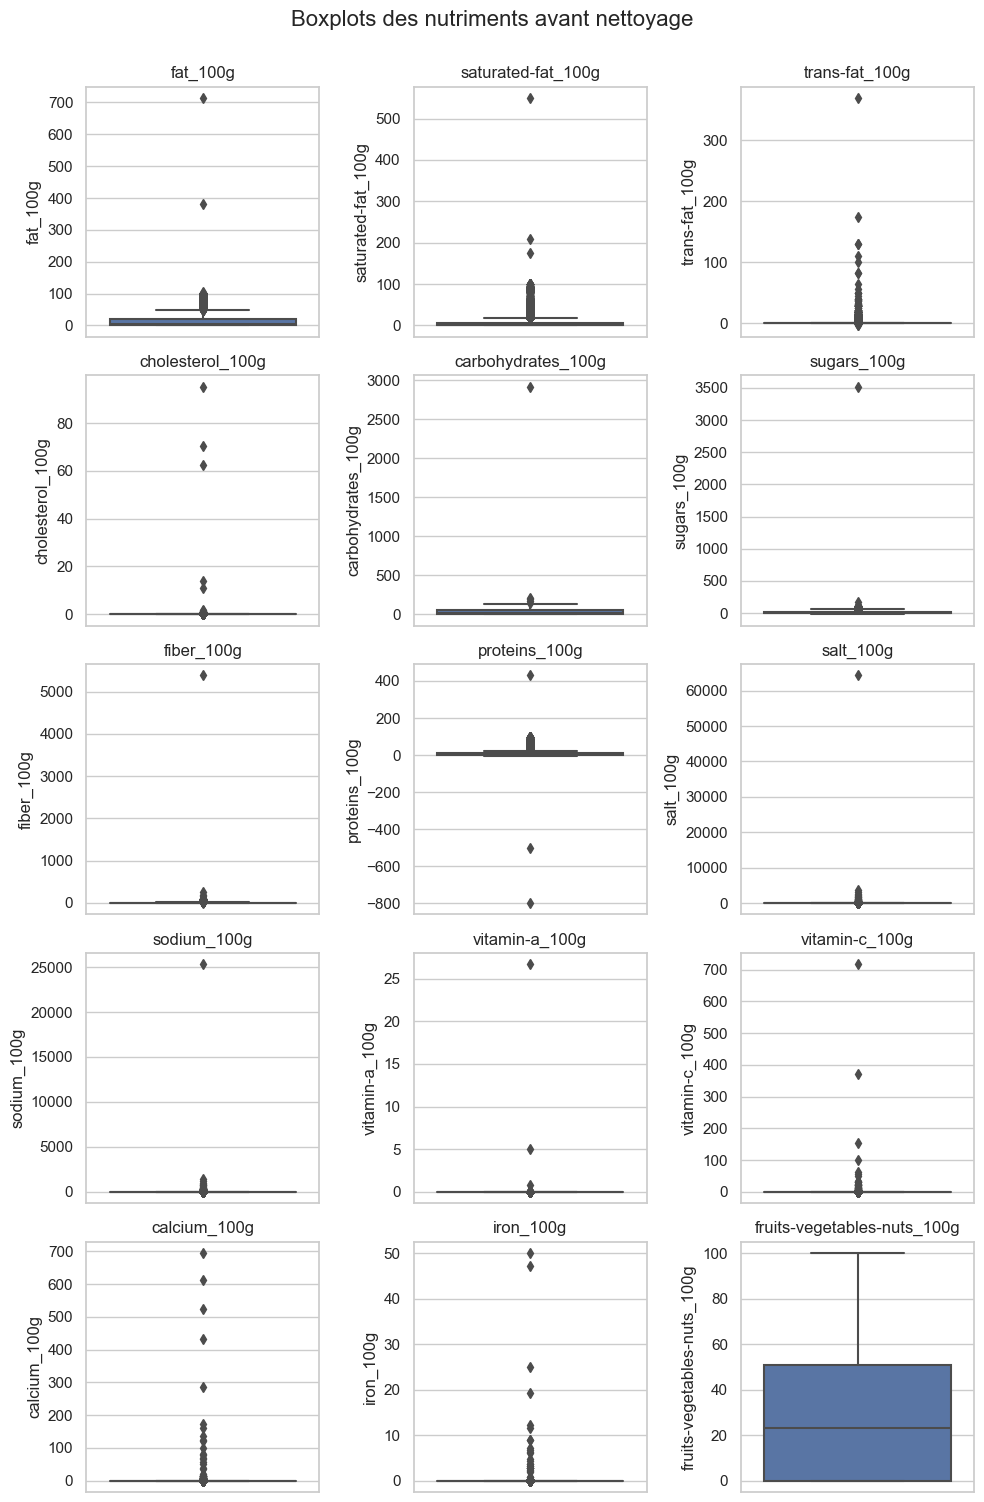

In [58]:
# Création d'un Dataframe dédié aux nutriments
df_nutriments = df_nutri[nutriments]

# Affichons les boxplots (répartition des valeurs) des nutriments
plt.figure(figsize=(10,15))

for i, colonne in enumerate(df_nutriments.columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(y=colonne, data=df_nutriments)
    plt.title(colonne)
    
# Ajouter un titre général au-dessus des sous-graphiques
plt.suptitle('Boxplots des nutriments avant nettoyage', fontsize=16, y=1)
    
# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

In [59]:
# Remplacez les valeurs en dehors de la plage [0, 100] par NaN
df_nutri[nutriments] = df_nutri[nutriments].where((df_nutri[nutriments] >= 0) & (df_nutri[nutriments] <= 100), np.nan)

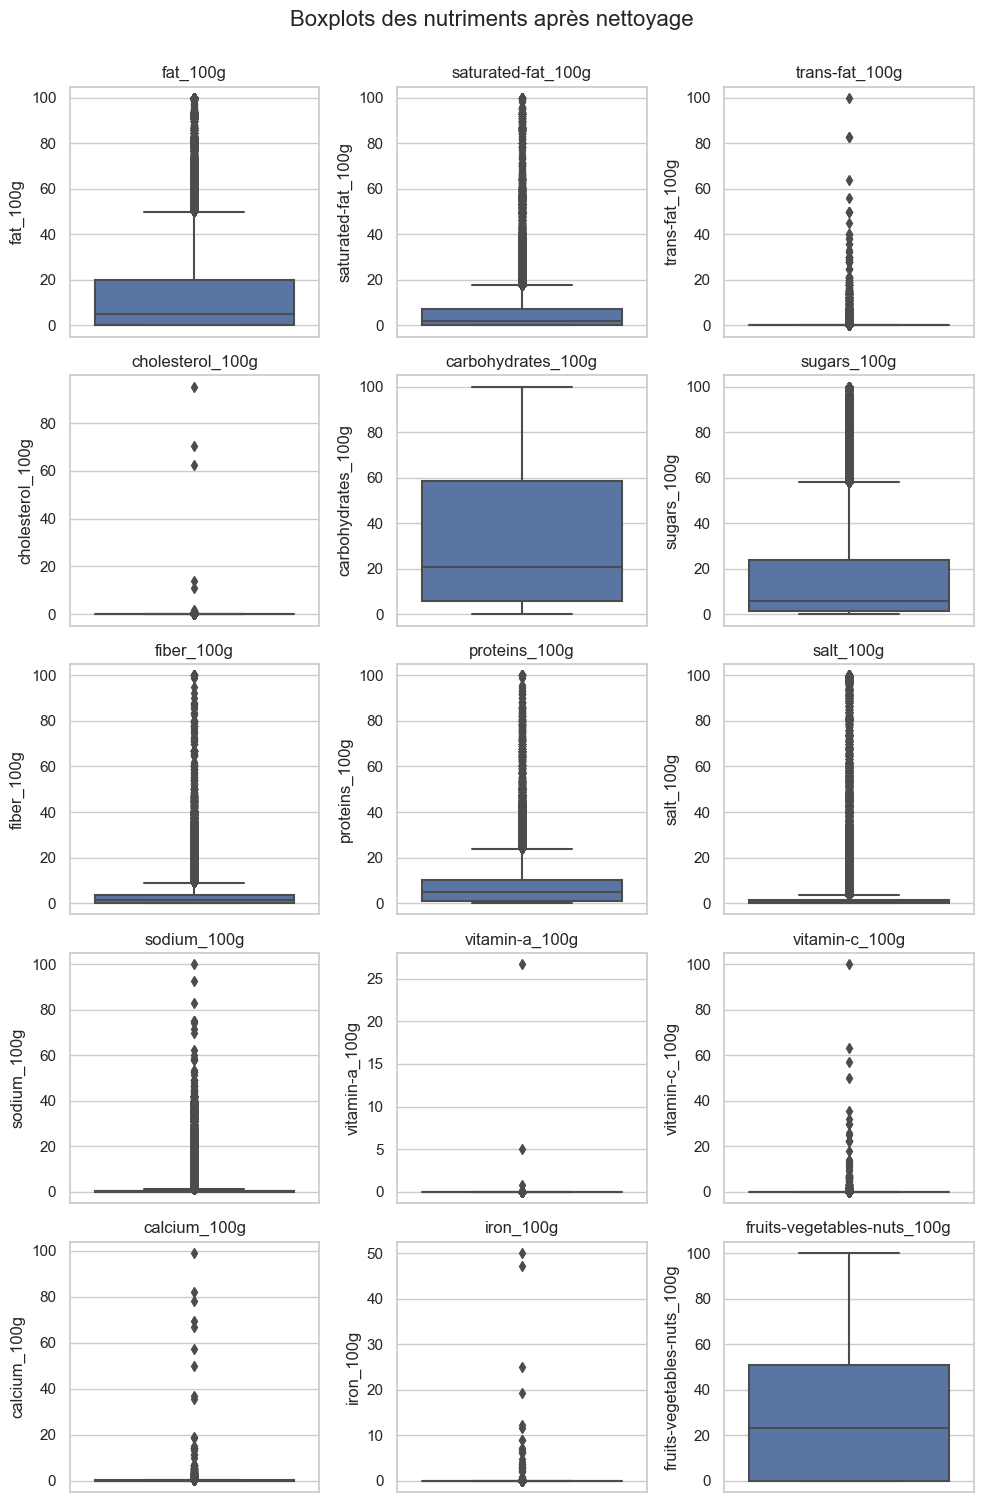

In [60]:
# Création d'un Dataframe dédié aux nutriments
df_nutriments = df_nutri[nutriments]

# Affichons les boxplots (répartition des valeurs) des nutriments
plt.figure(figsize=(10,15))

for i, colonne in enumerate(df_nutriments.columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(y=colonne, data=df_nutriments)
    plt.title(colonne)
    
# Ajouter un titre général au-dessus des sous-graphiques
plt.suptitle('Boxplots des nutriments après nettoyage', fontsize=16, y=1)
    
# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

#### 2.6.2 Pour l'énergie pour 100g  <a class="anchor" id="2_6_2"></a>

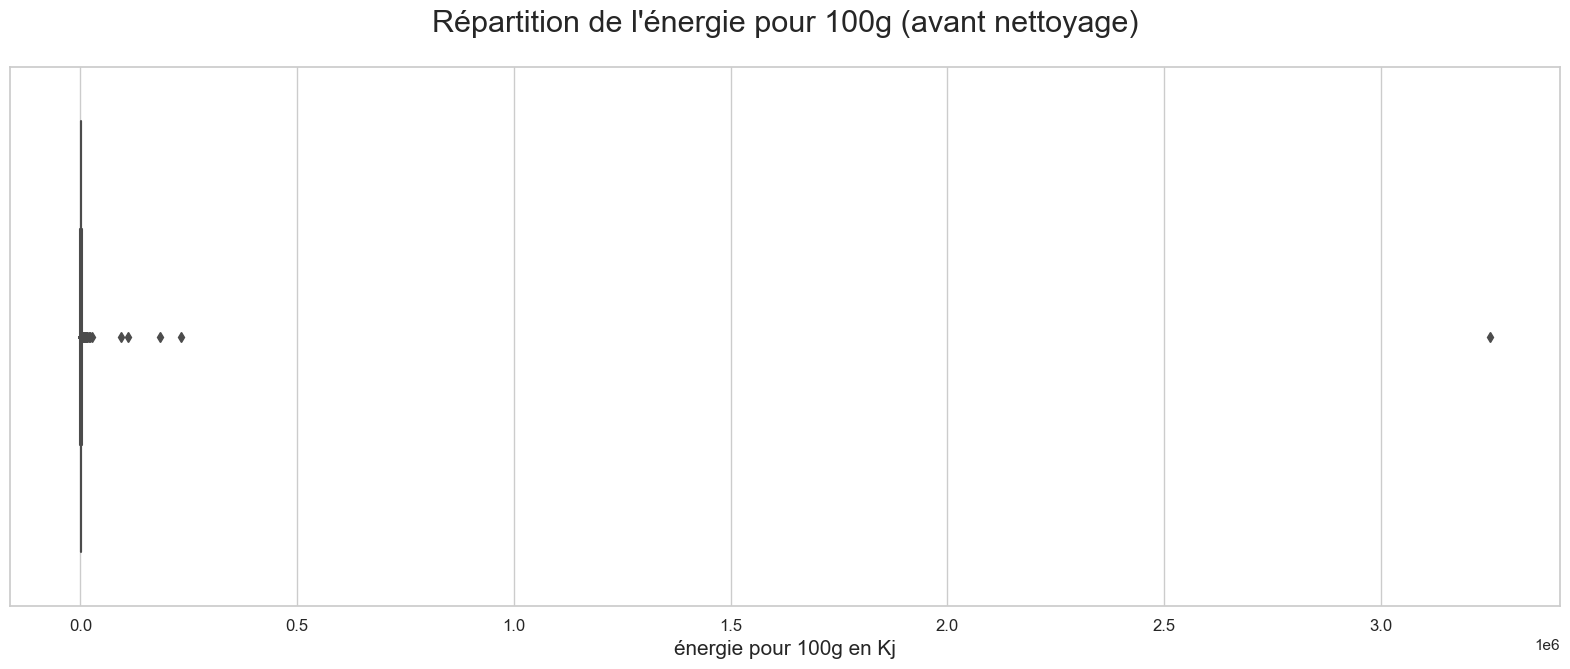

In [61]:
# Utilisons une boxplot pour visualiser cela
plt.figure(figsize=(20,7))
sns.set_style('whitegrid')
sns.boxplot(x=df_nutri['energy_100g'])
plt.title("Répartition de l'énergie pour 100g (avant nettoyage)", fontsize=22, y=1.05)
plt.xlabel('énergie pour 100g en Kj', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

Il est évident que nous avons ici une valeur aberrante, très probablement due à une erreur de saisie. Cependant, lorsque nous examinons les valeurs énergétiques des aliments, nous constatons que l'aliment le moins calorique est l'eau, avec 0 Kcal (0 Kj), tandis que les huiles (comme l'huile d'olive, de colza, de sésame, etc.) sont les aliments les plus caloriques, avec 900 Kcal (3700 Kj).

Nous allons donc remplacer les valeurs qui seraient en dehors de cet intervalle par des valeurs manquantes que nous calculerons par la suite.

In [62]:
# Remplacer les valeurs aberrantes par NaN pour la colonne 'energy_100g'
df_nutri['energy_100g'] = df_nutri['energy_100g'].where((df_nutri['energy_100g'] >= 0) & (df_nutri['energy_100g'] <= 3700), np.nan)

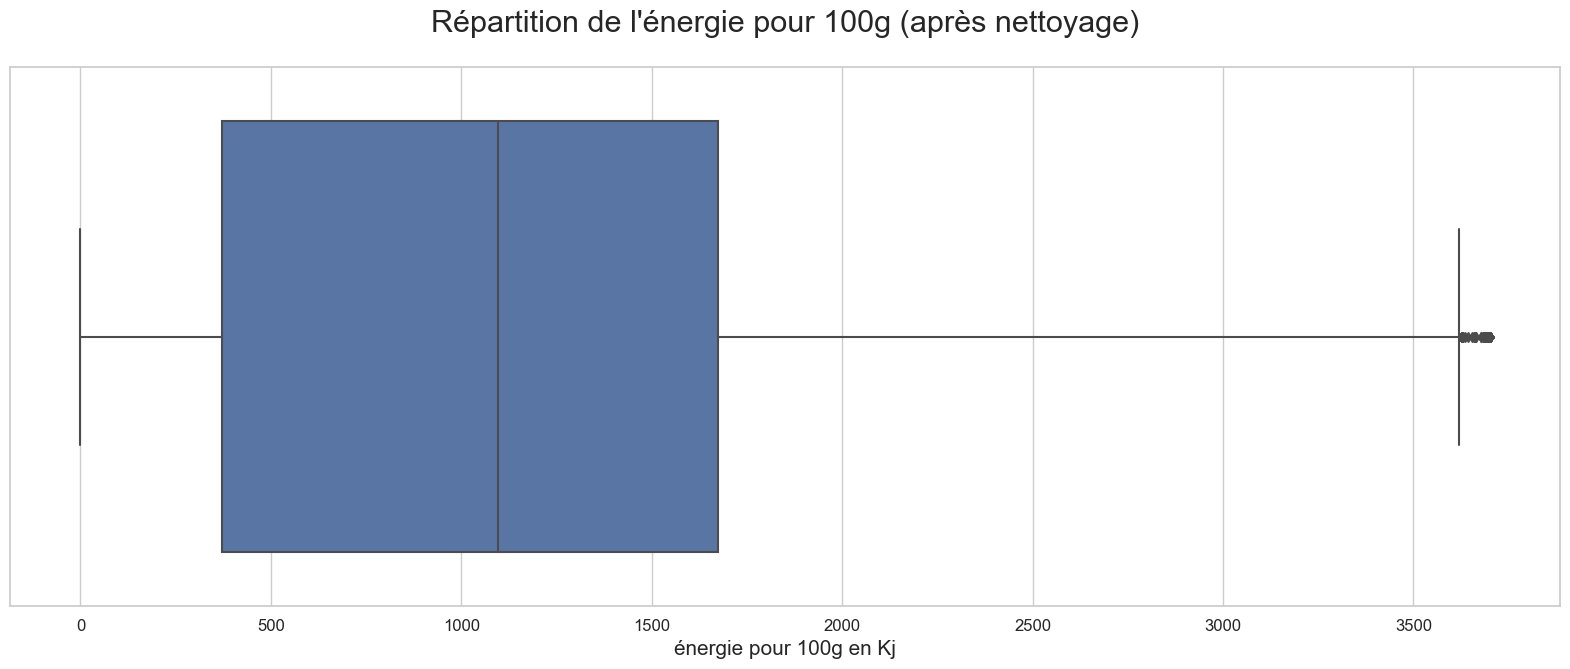

In [63]:
# Utilisons une boxplot pour visualiser cela
plt.figure(figsize=(20,7))
sns.set_style('whitegrid')
sns.boxplot(x=df_nutri['energy_100g'])
plt.title("Répartition de l'énergie pour 100g (après nettoyage)", fontsize=22, y=1.05)
plt.xlabel('énergie pour 100g en Kj', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

### 2.7 Gestion des valeurs manquantes <a class="anchor" id="2_7"></a>

In [64]:
# Affichons les valeurs manquantes
pourcentage(df_nutri, dict_type)

,Nom de la colonne,Pourcentage de valeurs manquantes,Type de variable
0,fruits-vegetables-nuts_100g,98.831775,quantitative
1,categories_fr,75.298895,qualitative
2,main_category_fr,75.298895,qualitative
3,pnns_groups_2,73.657524,qualitative
4,vitamin-a_100g,47.061135,quantitative
5,iron_100g,45.941072,quantitative
6,vitamin-c_100g,45.807374,quantitative
7,calcium_100g,45.739561,quantitative
8,trans-fat_100g,44.844513,quantitative
9,cholesterol_100g,44.536274,quantitative


#### 2.7.1 Les valeurs non estimables  <a class="anchor" id="2_7_1"></a>

Ici, étant donné l'impossibilité d'obtenir des estimations précises pour les valeurs manquantes, nous avons deux options pour les représenter de manière appropriée :
1. En substituant ces valeurs par un texte explicite signalant l'absence d'information lorsque la variable est qualitative.
2. En remplaçant ces valeurs par 0 lorsque la variable est quantitative.

In [65]:
# Pour les additifs
df_nutri['additives_fr'] = df_nutri['additives_fr'].fillna('sans additifs')
df_nutri['additives_n'] = df_nutri['additives_n'].fillna(0)

# Pour les marques
df_nutri['brands'] = df_nutri['brands'].fillna('non renseigné')

# Pour le nombre d'ingrédients issus de l'huile de palme
df_nutri['ingredients_from_palm_oil_n'] = df_nutri['ingredients_from_palm_oil_n'].fillna(0)

# Pour les catégories
df_nutri['main_category_fr'] = df_nutri['main_category_fr'].fillna('non renseigné')
df_nutri['categories_fr'] = df_nutri['categories_fr'].fillna('non renseigné')
df_nutri['pnns_groups_2'] = df_nutri['pnns_groups_2'].fillna('unknown')

# Pour les pays
df_nutri['countries_fr'] = df_nutri['countries_fr'].fillna('non renseigné')

#### 2.7.2 Les valeurs à imputer   <a class="anchor" id="2_7_2"></a>

On va imputer des valeurs pour les valeurs manquantes. Mais avant de choisir une méthode, on va en essayer 3 : 
* L'imputation par la moyenne,
* L'imputation par la médiane,
* L'imputation par la méthode des plus proches voisins (KNNImputer)

On va étudier les distributions pour chacune des méthode et voir laquelle serait la plus pertinente.

Commençons par regarder la distribution des variables avant l'imputation :

In [66]:
# Alimenter la liste des valeurs à imputer avec les noms de colonnes qui terminent par '_100g'
valeurs_à_imputer = []

for colonne in df_nutri.columns:
    if '_100g' in colonne:
        valeurs_à_imputer.append(colonne)

# Enlever l'énergie de la liste car les valeurs manquantes seront calculées par la suite
if 'energy_100g' in valeurs_à_imputer:
    valeurs_à_imputer.remove('energy_100g')

##### 2.7.2.1 Imputation par la moyenne   <a class="anchor" id="2_7_2_1"></a>

In [67]:
# Calculer la moyenne pour chaque colonne
mean_nutrients = df_nutri[valeurs_à_imputer].mean()

# Créer une copie du Dataframe 'df_nutri'
df_nutri_moy = df_nutri.copy()

# Remplacer les valeurs manquantes dans chaque colonne par leur moyenne respective
for colonne in valeurs_à_imputer:
    df_nutri_moy[colonne].fillna(mean_nutrients[colonne], inplace=True)

##### 2.7.2.2 Imputation par la médiane   <a class="anchor" id="2_7_2_2"></a>

In [68]:
# Calculer la médiane pour chaque colonne
median_nutrients = df_nutri[valeurs_à_imputer].median()

# Créer une copie du Dataframe 'df_nutri'
df_nutri_med = df_nutri.copy()

# Remplacer les valeurs manquantes dans chaque colonne par leur médiane respective
for colonne in valeurs_à_imputer:
    df_nutri_med[colonne].fillna(median_nutrients[colonne], inplace=True)

##### 2.7.2.3 Imputation par un KNNImputer   <a class="anchor" id="2_7_2_3"></a>

In [69]:
# On va mettre les valeurs de notre dataframe dans un np.array 'X'
X = df_nutri[valeurs_à_imputer].values

# On instancie le KNNImputer avec le nombre de voisins souhaité
imputer = KNNImputer(missing_values=np.nan, n_neighbors=2)

# On entraine le KNNImputer sur nos données et on remplace nos données manquantes par nos estimées
X_imputed = imputer.fit_transform(X)

In [70]:
# Créer une copie du Dataframe 'df_nutri'
df_nutri_knn = df_nutri[valeurs_à_imputer].copy()

# Remplacer les valeurs manquantes dans chaque colonne par les valeurs imputées par le KNNImputer
df_nutri_knn = pd.DataFrame(X_imputed, columns=df_nutri_knn.columns)
df_nutri_knn = df_nutri_knn.reset_index(drop=True)
df_nutri_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259539 entries, 0 to 259538
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   fat_100g                     259539 non-null  float64
 1   saturated-fat_100g           259539 non-null  float64
 2   trans-fat_100g               259539 non-null  float64
 3   cholesterol_100g             259539 non-null  float64
 4   carbohydrates_100g           259539 non-null  float64
 5   sugars_100g                  259539 non-null  float64
 6   fiber_100g                   259539 non-null  float64
 7   proteins_100g                259539 non-null  float64
 8   salt_100g                    259539 non-null  float64
 9   sodium_100g                  259539 non-null  float64
 10  vitamin-a_100g               259539 non-null  float64
 11  vitamin-c_100g               259539 non-null  float64
 12  calcium_100g                 259539 non-null  float64
 13 

In [71]:
df_nutri_knn.shape

(259539, 16)

##### 2.7.2.4 Comparaison des méthodes   <a class="anchor" id="2_7_2_4"></a>

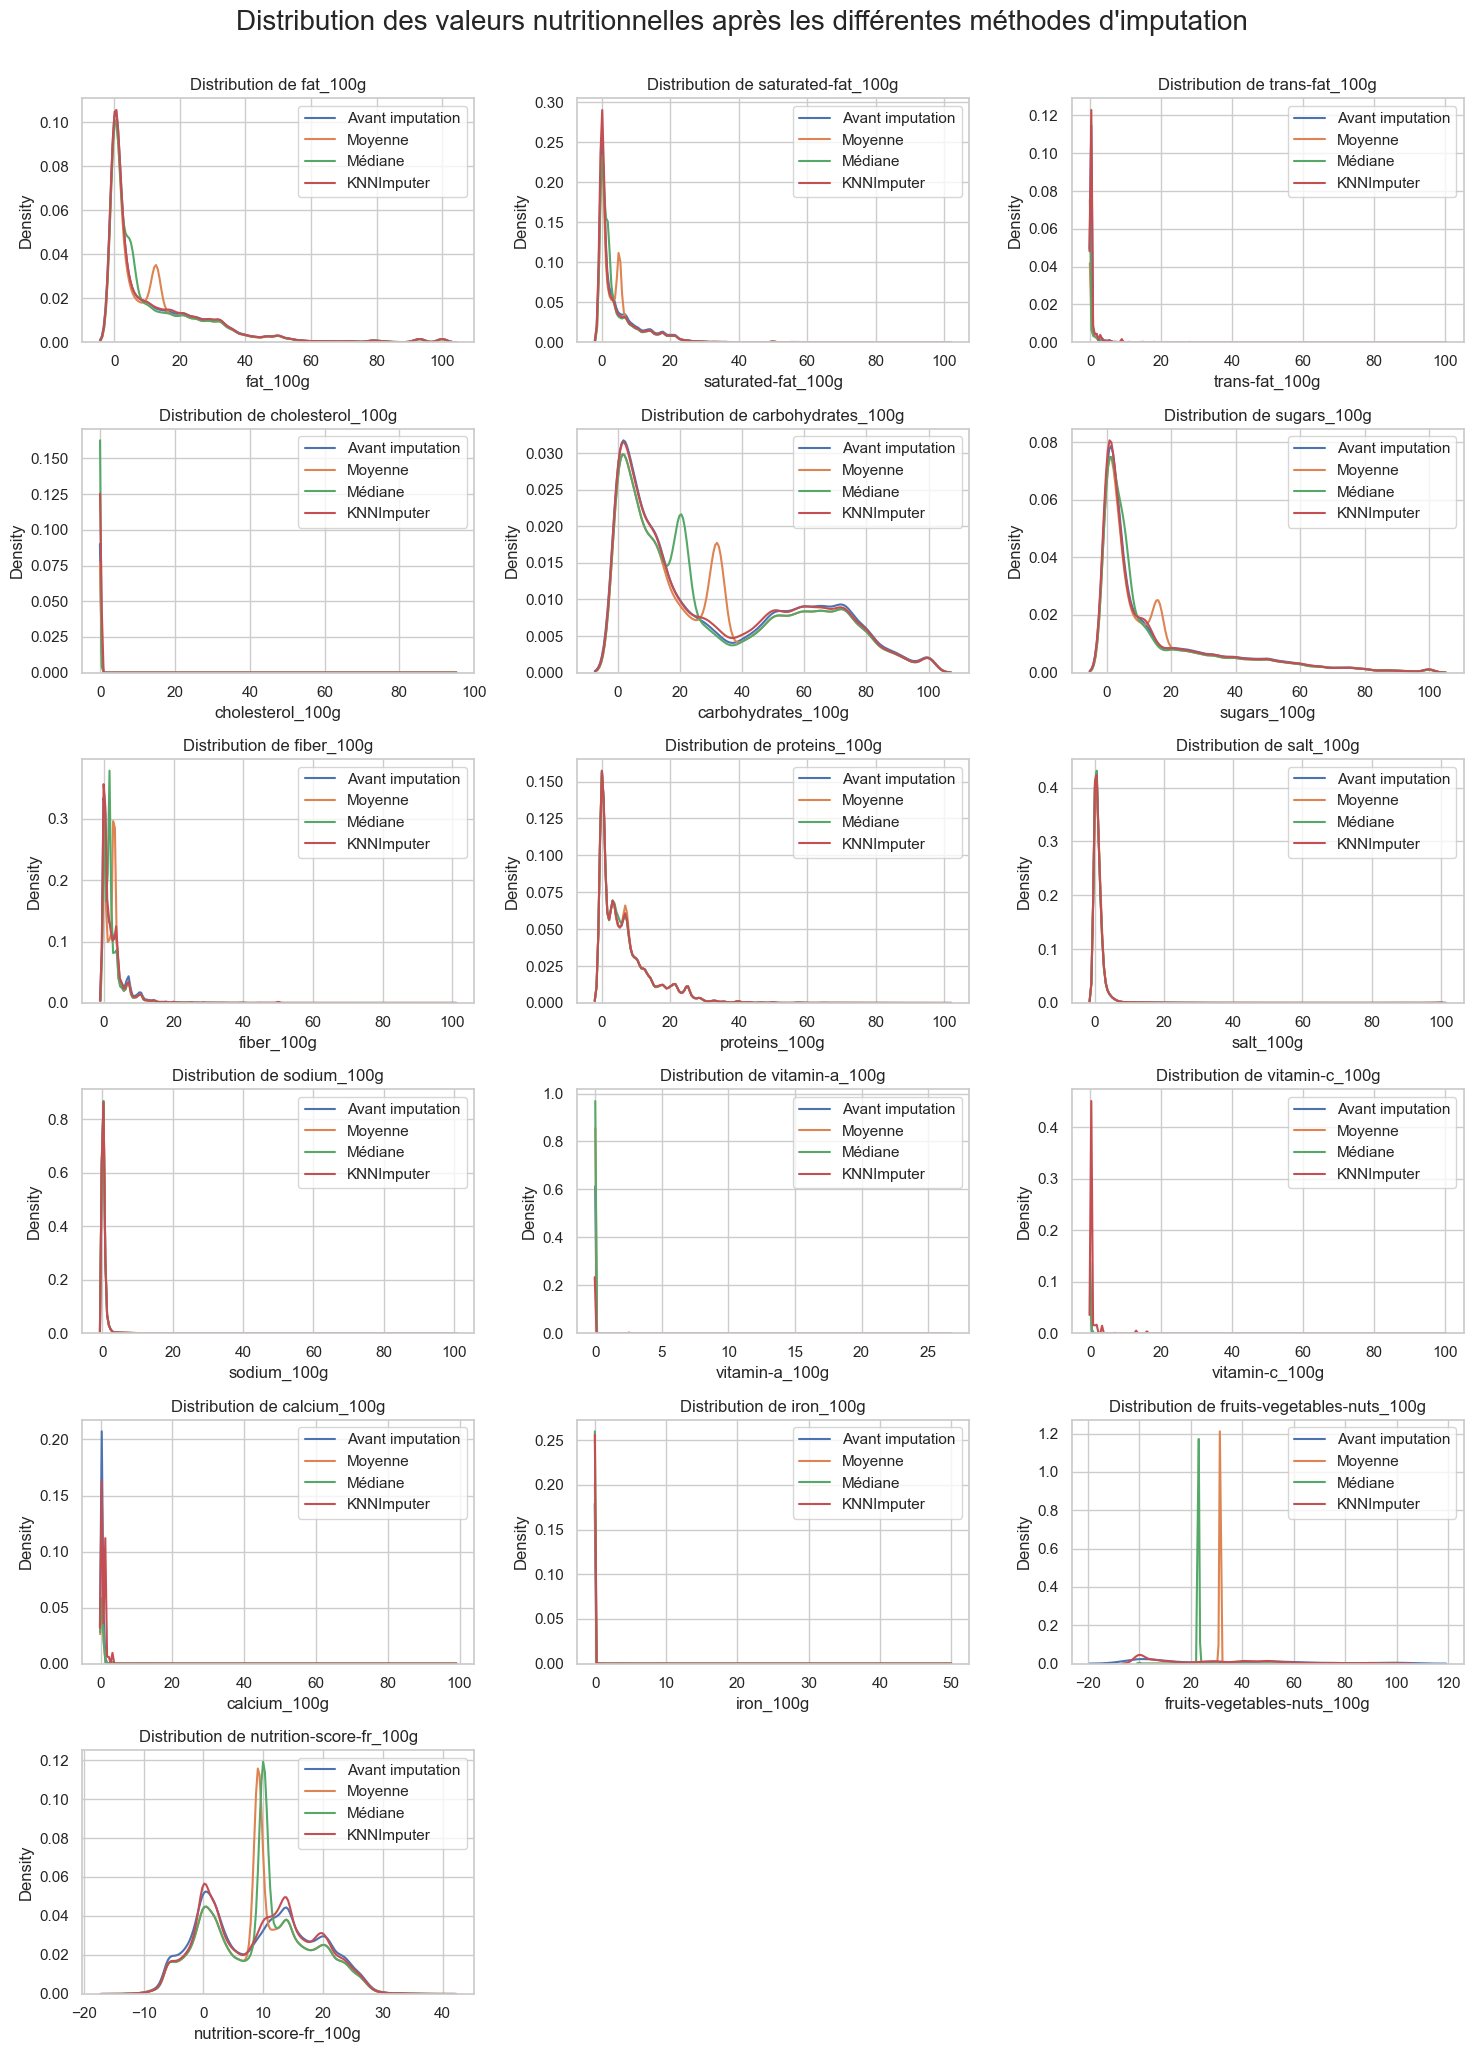

In [72]:
# Créez une liste des DataFrames pour chaque méthode d'imputation
imputed_dfs = [df_nutri, df_nutri_moy, df_nutri_med, df_nutri_knn]
imputation_methods = ['Avant imputation', 'Moyenne', 'Médiane', 'KNNImputer']

# Visualisation en KDE plot des distributions suivant l'imputation
plt.figure(figsize=(15,20))

for i, valeurs in enumerate(valeurs_à_imputer):
    plt.subplot(6, 3, i+1)
    
    # Créer des KDE plots pour chaque méthode d'imputation
    for j, df in enumerate(imputed_dfs):
        sns.kdeplot(df[valeurs], label=imputation_methods[j])
    
    plt.title(f'Distribution de {valeurs}')
    plt.legend()  # Affiche la légende pour distinguer les méthodes d'imputation

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Ajouter un titre général
plt.suptitle("Distribution des valeurs nutritionnelles après les différentes méthodes d'imputation", fontsize=20, y=1.025)
plt.show()

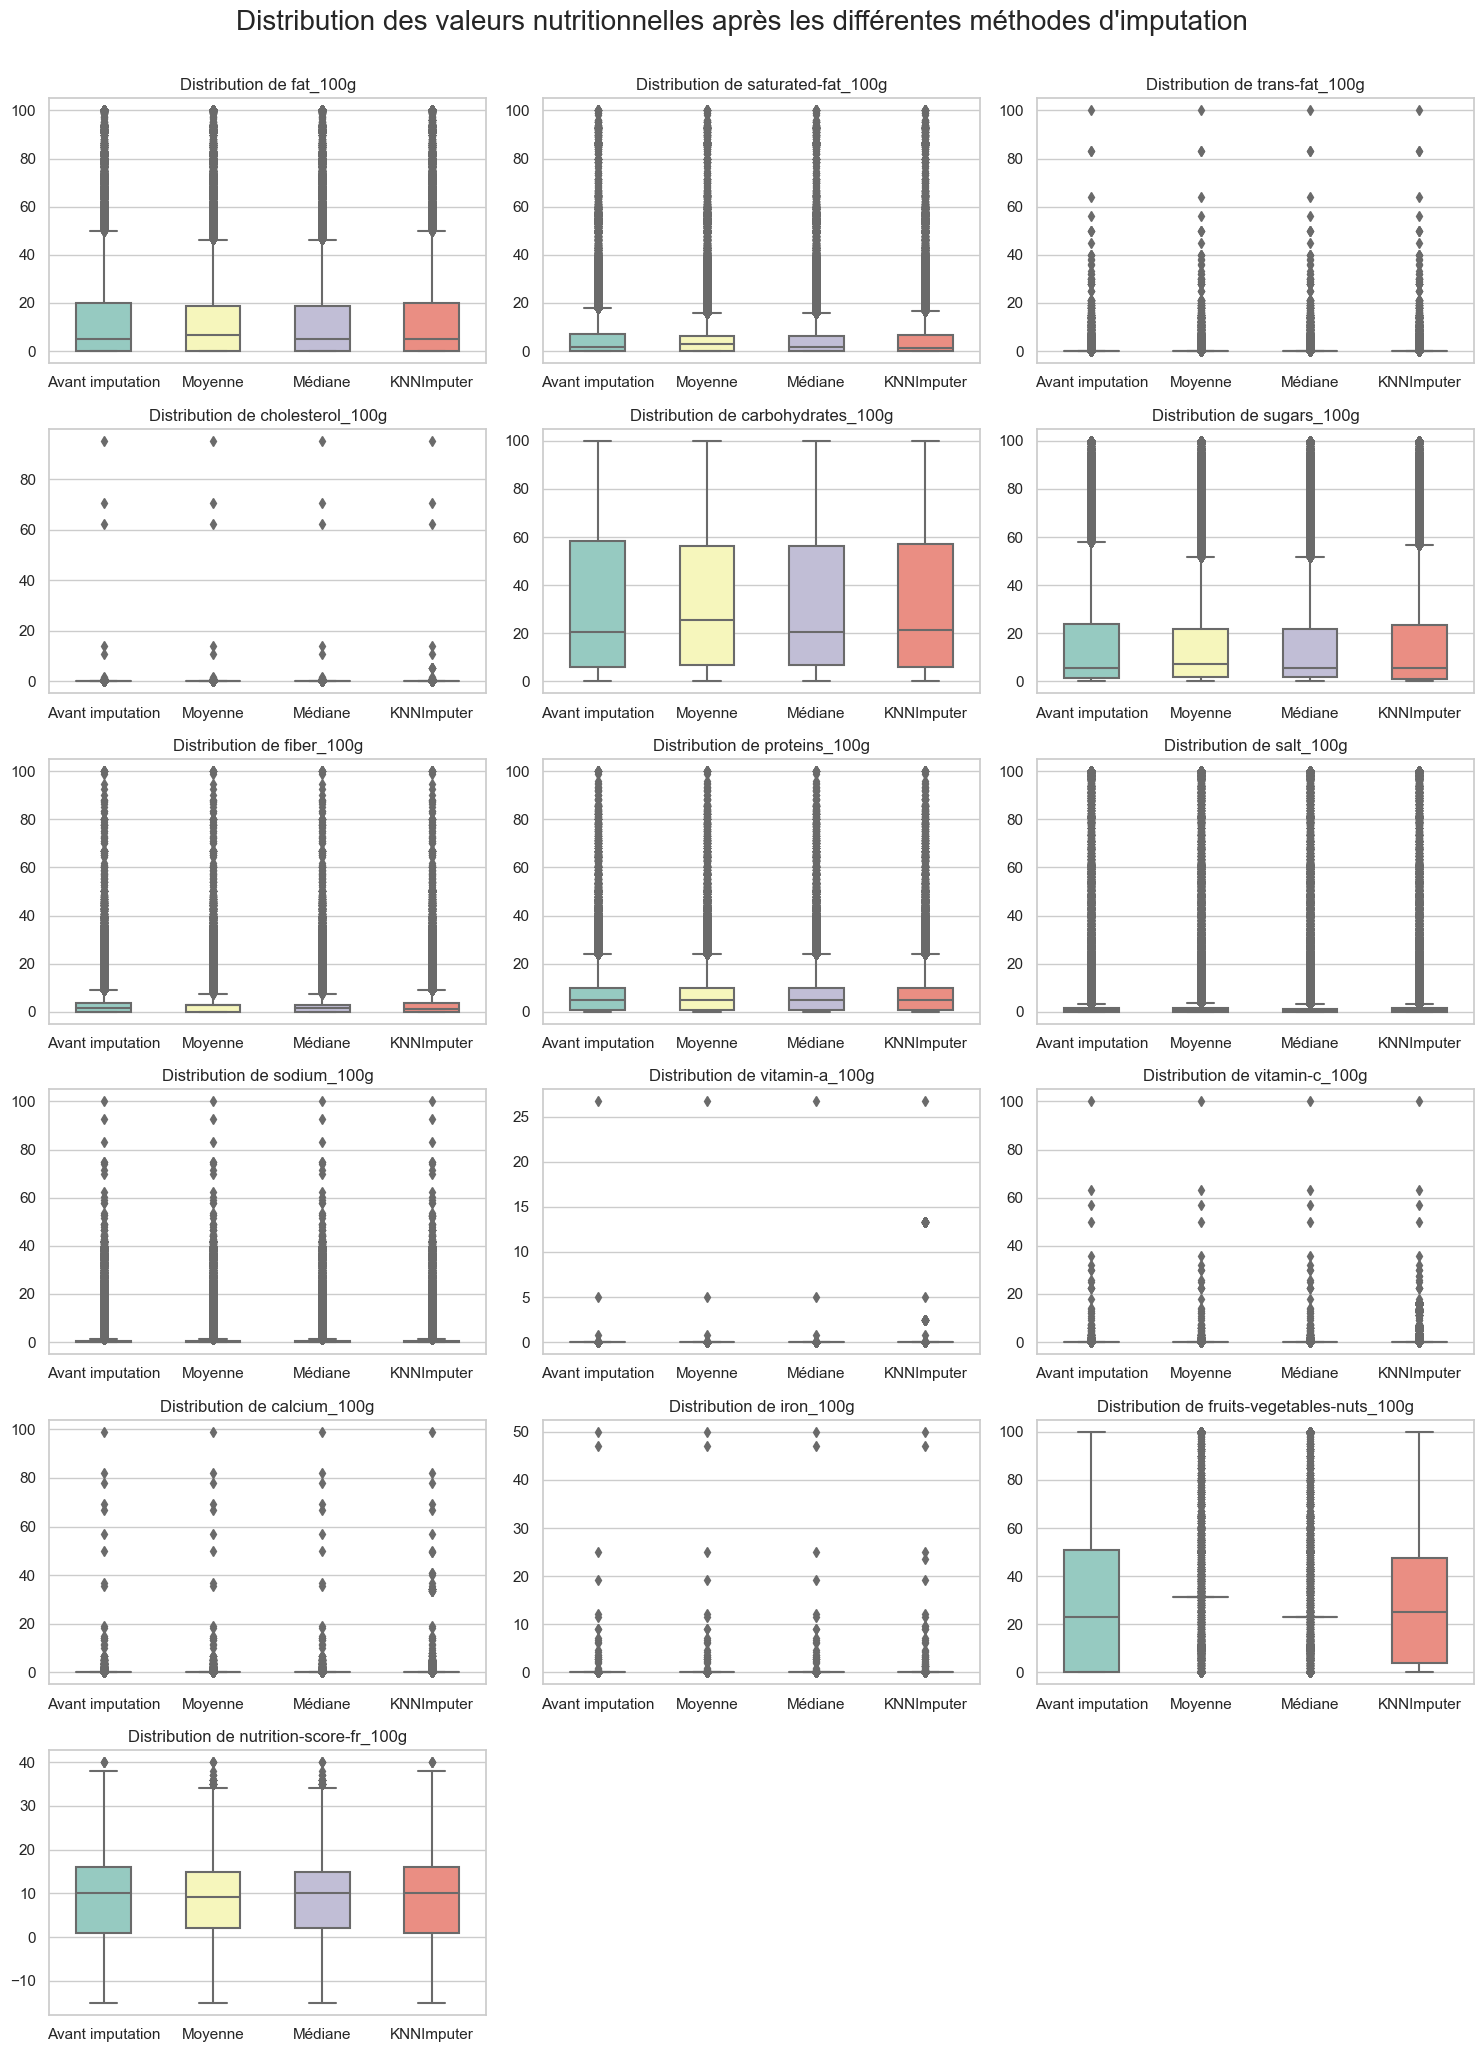

In [73]:
# Visualisation en boxplot des distributions suivant l'imputation
plt.figure(figsize=(15, 20))

for i, valeurs in enumerate(valeurs_à_imputer):
    plt.subplot(6, 3, i+1)
    
    # Créer des boxplots pour chaque méthode d'imputation
    data_to_plot = []
    for j, df in enumerate(imputed_dfs):
        data_to_plot.append(df[valeurs])
    
    sns.boxplot(data=data_to_plot, palette="Set3", width=0.5)
    plt.title(f'Distribution de {valeurs}')
    plt.xticks(range(4), imputation_methods)  # Remplace les étiquettes de l'axe x par les noms des méthodes

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Ajouter un titre général
plt.suptitle("Distribution des valeurs nutritionnelles après les différentes méthodes d'imputation", fontsize=20, y=1.025)
plt.show()

Il est maintenant temps de choisir le type d'imputation que nous allons utiliser.

Nous pouvons constater que les distributions des nutriments ne suivent pas une forme gaussienne, ce qui signifie qu'elles ne sont pas normalement distribuées. Par conséquent, il est déjà clair que l'imputation par la moyenne ne serait pas une bonne idée. En effet, le KNNImputer ne suppose pas que les données suivent une distribution particulière, contrairement à la moyenne qui serait très sensible aux valeurs atypiques.

En suivant cette logique, nous savons que la médiane est moins sensible à ces valeurs extrêmes, ce qui permettra de conserver nos valeurs atypiques identifiables et de ne pas altérer la distribution de nos variables.

Cependant, étant donnée la complexité des données et les variations possibles entre différents aliments en termes de nutriments, il est judicieux d'utiliser une méthode de plus proches voisins pour que l'imputation identifie plusieurs groupes d'aliments.

Par conséquent, nous utiliserons le KNNImputer pour remplacer les données manquantes.

In [74]:
# Remplacer les valeurs manquantes dans df_nutri par les valeurs imputées par le KNNImputer
df_nutri = df_nutri.reset_index(drop=True)
df_nutri[valeurs_à_imputer] = df_nutri_knn
df_nutri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259539 entries, 0 to 259538
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   code                         259539 non-null  object 
 1   product_name                 259539 non-null  object 
 2   brands                       259539 non-null  object 
 3   categories_fr                259539 non-null  object 
 4   countries_fr                 259539 non-null  object 
 5   additives_n                  259539 non-null  float64
 6   additives_fr                 259539 non-null  object 
 7   ingredients_from_palm_oil_n  259539 non-null  float64
 8   nutrition_grade_fr           218463 non-null  object 
 9   pnns_groups_2                259539 non-null  object 
 10  main_category_fr             259539 non-null  object 
 11  energy_100g                  257149 non-null  float64
 12  fat_100g                     259539 non-null  float64
 13 

#### 2.7.3 Calcul de l'énergie pour 100g <a class="anchor" id="2_7_3"></a>

Quelques informations interressantes pour le calcul sont disponibles ici : https://fr.openfoodfacts.org/guide-pour-les-producteurs. 

L'énergie est en Kj et nous utiliserons les coefficients d'Atwater pour calculer les valeurs manquantes. Cela nous donnera un nombre de kcal que nous pourrons convertir en Kj.

In [75]:
# Remplacez les NaN dans la colonne "energy_100g" par le calcul de l'énergie en kJ
df_nutri['energy_100g'].fillna(((df_nutri['proteins_100g'] * 4) + (df_nutri['carbohydrates_100g'] * 4) + (df_nutri['fat_100g'] * 9))*4.184, inplace=True)

#### 2.7.4 Calcul des grades des nutris-scores  <a class="anchor" id="2_7_4"></a>

Les grades, lettre allant de A à E sont obtenus de la manière suivante : 

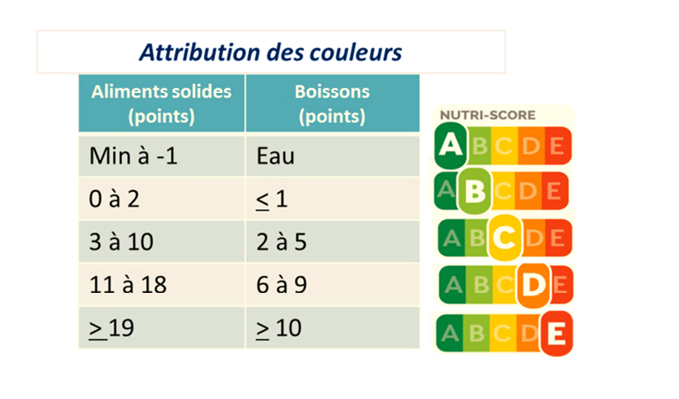

Seulement, il semble compliqué de faire la distinction entre les produits type 'aliments solides' et les produits type 'boissons'.
Regardons de plus prêt les variables correspondant aux catégories :

In [76]:
print("Le nombre de catégories uniques pour la variable 'categories_fr' est de :", df_nutri.categories_fr.nunique())
print()
print("Le nombre de catégories uniques pour la variable 'main_category_fr' est de :", df_nutri.main_category_fr.nunique())
print()
print("Le nombre de catégories uniques pour la variable 'pnns_groups_2' est de :", df_nutri.pnns_groups_2.nunique())

Le nombre de catégories uniques pour la variable 'categories_fr' est de : 16516

Le nombre de catégories uniques pour la variable 'main_category_fr' est de : 2359

Le nombre de catégories uniques pour la variable 'pnns_groups_2' est de : 42


Il semble donc compliqué de trouver une catégorie boisson dans 'categories_fr' ou bien même dans 'main_category_fr.
Par contre, on peut regarder dans 'pnns_group_2'.

In [77]:
# Création d'une liste des valeurs uniques de 'pnns_groups_2'
categories = df_nutri['pnns_groups_2'].to_list()
categories = list(set(categories))
categories

['Meat',
 'Cereals',
 'Artificially sweetened beverages',
 'Biscuits and cakes',
 'Fruit juices',
 'fruits',
 'Non-sugared beverages',
 'vegetables',
 'Vegetables',
 'Fruits',
 'pastries',
 'Salty and fatty products',
 'Pizza pies and quiche',
 'Bread',
 'cereals',
 'Dressings and sauces',
 'One-dish meals',
 'unknown',
 'Cheese',
 'Processed meat',
 'nuts',
 'Ice cream',
 'Sandwich',
 'Dairy desserts',
 'Soups',
 'Eggs',
 'Fats',
 'legumes',
 'Dried fruits',
 'Tripe dishes',
 'Fish and seafood',
 'Sweetened beverages',
 'Sweets',
 'Milk and yogurt',
 'Breakfast cereals',
 'Appetizers',
 'Legumes',
 'Potatoes',
 'Chocolate products',
 'Fruit nectars',
 'Alcoholic beverages',
 'Nuts']

Pour le cas de l'eau, il semble compliqué de retrouver la catégorie. Regardons pour les 'Non-sugared beverages' : 

In [78]:
df_nutri.loc[df_nutri['pnns_groups_2'] == 'Non-sugared beverages']

,code,product_name,brands,categories_fr,countries_fr,additives_n,additives_fr,ingredients_from_palm_oil_n,nutrition_grade_fr,pnns_groups_2,main_category_fr,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
534,00071543,Aloe Vera Grape & Apple Juice,M&S,"Aliments et boissons à base de végétaux,Boisso...",France,0.0,sans additifs,0.0,e,Non-sugared beverages,Boissons,155.0,2.150,0.1,0.0,0.0000,39.55,8.50,0.10,0.10,0.100000,0.039370,0.000215,0.04300,0.01730,0.000120,50.0,12.0
740,00088978,Fresh Drinking Coconut,Marks & Spencer,"Boissons,Boissons non sucrées,en:Boissons-a-ba...","France,Royaume-Uni",0.0,sans additifs,0.0,b,Non-sugared beverages,Boissons,0.0,0.000,0.0,0.0,0.0000,28.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,1.00000,0.00000,0.000000,0.0,0.0
6643,0011156054502,British Blend Premium Black Tea,Tetley,"Aliments et boissons à base de végétaux,Boisso...",États-Unis,0.0,sans additifs,0.0,NaN,Non-sugared beverages,Thés,0.0,0.000,0.0,0.0,0.0000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,21.5,0.0
9653,0011645004315,Honey Soy Drink,Sacramento Tofu Co.,"Aliments et boissons à base de végétaux,Boisso...",États-Unis,0.0,sans additifs,0.0,b,Non-sugared beverages,Boissons,199.0,0.625,0.0,0.0,0.0000,8.75,7.92,0.00,2.08,0.000000,0.000000,0.000000,0.00250,0.00833,0.000300,50.0,0.0
10053,0012000039218,Brisk Iced Tea Lemon,"Lipton,Brisk","Boissons,Thés glacés,Boissons non sucrées",États-Unis,0.0,sans additifs,0.0,NaN,Non-sugared beverages,Boissons,93.1,0.000,0.0,0.0,0.0065,5.56,5.56,3.55,0.00,0.074100,0.029200,0.000536,0.07350,0.04550,0.000915,25.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259425,9501071050204,Jabal Akhdar Pure Natural Water,"Pure Natural Water,Jabal Akhdar","Boissons,Eaux,Boissons non sucrées",en:سلطنة-عمان,0.0,sans additifs,0.0,b,Non-sugared beverages,Eaux,0.0,0.000,0.0,0.0,0.0000,0.00,0.00,0.00,0.00,0.015113,0.005950,0.000000,3.15125,1.25000,0.000270,0.0,0.0
259461,9556041608251,Lait de Coco,Ayam,"Aliments et boissons à base de végétaux,Boisso...",France,3.0,"E412 - Gomme de guar,E407 - Carraghénanes,E415...",0.0,d,Non-sugared beverages,Laits,862.0,20.000,18.0,0.0,0.0000,3.40,2.70,0.50,2.10,0.050038,0.019700,0.000650,0.00250,0.01950,0.000037,0.0,12.0
259475,9556041612081,Ayam Pure Coconut Water,Ayam,"Aliments et boissons à base de végétaux,Boisso...","Australie,France",0.0,sans additifs,0.0,b,Non-sugared beverages,Fruits,76.1,0.000,0.0,0.0,0.0065,4.55,4.00,0.00,0.00,0.088500,0.034800,0.000650,0.07350,0.01750,0.000305,100.0,-4.0
259491,9556156046641,Yeo's Soy Bean Drink,Yeo's,"Aliments et boissons à base de végétaux,Boisso...",France,0.0,sans additifs,0.0,e,Non-sugared beverages,Boissons,222.0,2.200,0.2,3.0,0.0000,6.50,8.30,0.00,2.00,0.010000,0.003937,0.000000,0.00440,0.00460,0.000003,46.0,14.0


En effet, la catégorie 'Eaux' est incluse dans la colonne 'main_category_fr', où l'on recense un total de 2569 catégories différentes. Compte tenu de cette diversité de catégories, il semble complexe de mettre en place un calcul basé uniquement sur les informations de cette colonne.

Cependant, une solution possible consiste à attribuer le grade 'a' aux produits de la catégorie 'Eaux'. Cette approche est réalisable maintenant que nous avons identifié les produits appartenant à la catégorie 'Eaux' grâce à la colonne 'main_category_fr'.

In [79]:
# Utiliser un mask pour repérer les valeurs manquantes dans grade
mask_nan = df_nutri['nutrition_grade_fr'].isna()

# Attribuer le grade 'a' pour les eaux en créant un mask pour les eaux
mask_eaux = df_nutri['main_category_fr'].str.contains('Eaux')
df_nutri.loc[mask_eaux & mask_nan, 'nutrition_grade_fr'] = 'a'

On va continuer avec la liste des catégories que l'on retrouve dans 'pnns_groups_2'.

In [80]:
# Utiliser un mask pour repérer les valeurs manquantes dans grade
mask_nan = df_nutri['nutrition_grade_fr'].isna()

# Création d'un mask pour les boissons à partir de 'pnns_groups_2'
mask_boissons = df_nutri['pnns_groups_2'].str.contains('beverages|juices|nectars|Soups', case=False, na=False)

# Utilisation de la fonction grade_boissons pour attribuer le grade suivant le calcul
df_nutri.loc[mask_boissons & mask_nan, 'nutrition_grade_fr'] = df_nutri['nutrition-score-fr_100g'][mask_boissons].apply(lambda score: grade_boissons(score))

Nous allons donc partir du principe que les valeurs manquantes restantes pour le nutrition_grade_fr sont des aliments.

In [81]:
# Utiliser un mask pour repérer les valeurs manquantes dans grade
mask_nan = df_nutri['nutrition_grade_fr'].isna()

# Utilisation de la fonction grade_aliments pour attribuer le grade suivant le calcul
df_nutri.loc[mask_nan, 'nutrition_grade_fr'] = df_nutri['nutrition-score-fr_100g'][mask_nan].apply(lambda score: grade_aliments(score))

#### 2.7.5 Affichage des informations du Dataframe nettoyé   <a class="anchor" id="2_7_5"></a>

In [82]:
# Affichons le .info()
df_nutri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259539 entries, 0 to 259538
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   code                         259539 non-null  object 
 1   product_name                 259539 non-null  object 
 2   brands                       259539 non-null  object 
 3   categories_fr                259539 non-null  object 
 4   countries_fr                 259539 non-null  object 
 5   additives_n                  259539 non-null  float64
 6   additives_fr                 259539 non-null  object 
 7   ingredients_from_palm_oil_n  259539 non-null  float64
 8   nutrition_grade_fr           259539 non-null  object 
 9   pnns_groups_2                259539 non-null  object 
 10  main_category_fr             259539 non-null  object 
 11  energy_100g                  259539 non-null  float64
 12  fat_100g                     259539 non-null  float64
 13 

Nous pouvons considérer maintenant que toutes les données sont propres et pouvons passer à la suite de l'analyse.

## 3. Enregistrement du fichier csv propre <a class="anchor" id="3"></a>

In [83]:
# Export du nouveau Dataframe en CSV
chemin_fichier_csv = 'C:\\Users\\Basti\\Projets Python\\Machine Learning Engineer\\P2_Préparez des données pour un organisme de santé publique\\df_nutri.csv'
df_nutri.to_csv(chemin_fichier_csv, index=False)